# Flatiron Phase 3 Project

## Aaron Galbraith

### Submitted: July 12, 2023

# Business Understanding

A number of organizations install and manage water wells throughout the country of Tanzania to provide potable water to the population. Some of these wells become non-functional from time to time and need to be repaired or replaced. The government of Tanzania funds over 9,000 of these wells (about 15% of them).

Our analysis can help the government understand trends that are associated with wells that become non-functional. This can help the Tanzanian Government primarily in two ways.

1. The government can consider implementing changes in *how* (and *where*) they set up future wells so that wells have a better chance of remaining functional for a longer time without needing repair or replacement.

Of course, the government's broader goal is presumably to use their resources as efficiently as possible in delivering potable drinking water to as many residents who need it as possible. For this reason, the government surely must make choices according to some constraints that are beyond the bounds of our analysis, such as the availability or cost of certain installation options or the location choices for well placement. It could be that our recommendations for optimal well performance are incompatible with the conditions the government must deal with. For example, we may tell them to avoid installing wells in certain areas, but that might result in depriving people of water in those areas.

2. In the cases where these changes cannot be implemented, the government can more closely monitor wells that are likely to be at risk for needing repair or replacement.

It should be noted that we will eventually face a decision as to which type of error we consider the worse one in this exploration, false positives or false negatives. While neither type of error is desireable, we believe that false negatives — misidentifying non-functional wells as functional — is the worse type, as it results in depriving people of drinking water. False positives — misidentifying functional wells as non-functional — results in unneeded attention and resources being devoted to wells that are already serving effectively.

# Data Understanding

## Import files

Here we'll import all the tools we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from itertools import combinations

import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from scipy import stats
from scipy.interpolate import make_interp_spline

from xgboost import XGBClassifier

SEED = 10

The data package includes four documents. We'll open these and briefly examine their contents one at a time.

In [2]:
df = pd.read_csv('../data/training_set_values.csv')
# show row and column counts
df.shape

(59400, 40)

In [3]:
# show first few records
df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

The file "training_set_values" has 59,400 records (the wells) with 40 columns of details about those wells.

In [4]:
df = pd.read_csv('../data/training_set_labels.csv')
# show row and column counts
df.shape

(59400, 2)

In [5]:
# show first few records
df.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

In [6]:
# show value counts for the target variable
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The file "training_set_labels" just tells what the status of those 59,400 wells is, i.e. whether the well is functional.

In [7]:
df = pd.read_csv('../data/test_set_values.csv')
# show row and column counts
df.shape

(14850, 40)

In [8]:
# show first few records
df.head()

id  amount_tsh date_recorded                  funder  gps_height  \
0  50785         0.0    2013-02-04                    Dmdd        1996   
1  51630         0.0    2013-02-04  Government Of Tanzania        1569   
2  17168         0.0    2013-02-01                     NaN        1567   
3  45559         0.0    2013-01-22              Finn Water         267   
4  49871       500.0    2013-03-27                  Bruder        1260   

    installer  longitude   latitude                 wpt_name  num_private  \
0        DMDD  35.290799  -4.059696  Dinamu Secondary School            0   
1         DWE  36.656709  -3.309214                  Kimnyak            0   
2         NaN  34.767863  -5.004344           Puma Secondary            0   
3  FINN WATER  38.058046  -9.418672           Kwa Mzee Pange            0   
4      BRUDER  35.006123 -10.950412          Kwa Mzee Turuka            0   

   ... payment_type water_quality quality_group      quantity  quantity_group  \
0  ...    never pay          soft          good      seasonal        seasonal   
1  ...    never pay          soft          good  insufficient    insufficient   
2  ...    never pay          soft          good  insufficient    insufficient   
3  ...      unknown          soft          good           dry             dry   
4  ...      monthly          soft          good        enough          enough   

                 source           source_type  source_class  \
0  rainwater harvesting  rainwater harvesting       surface   
1                spring                spring   groundwater   
2  rainwater harvesting  rainwater harvesting       surface   
3          shallow well          shallow well   groundwater   
4                spring                spring   groundwater   

      waterpoint_type waterpoint_type_group  
0               other                 other  
1  communal standpipe    communal standpipe  
2               other                 other  
3               other                 other  
4  communal standpipe    communal standpipe  

[5 rows x 40 columns]

The file "test_set_values" is just like training_set_values, with fewer records (14,850).

In [9]:
df = pd.read_csv('../data/SubmissionFormat.csv')
# show row and column counts
df.shape

(14850, 2)

In [10]:
# show first few records
df.head()

id     status_group
0  50785  predicted label
1  51630  predicted label
2  17168  predicted label
3  45559  predicted label
4  49871  predicted label

The file "SubmissionFormat" is like training_set_labels except the contestant/data scientist has to provide the labels.

## Summary of available files

There is a training set consisting of 59,400 records; a set of labels for those 59,400 records; a test set consisting of 14,850 records; and a template for submitting labels for those 14,850 test records to an online contest.

Because we do not have labels for the 14,850 records in the test set, those records unfortunatey have no value to us. We will have to carve out training and test sets from just the 59,400 records with known labels.

## Create the desired data set

As we drop records from the data set, we'll need to make sure we drop the *same* records from the target labels, so it will be necessary to join those two dataframes together first.

### * Special note:

*As we'll explore a bit later, many of the "gps_height" values were found to be nonsensical zero values. In a separate notebook we retrieved many of the missing values for this feature that would be relevant to our data set here (i.e. elevations for records whose funder is the tanzanian government). In the next cell, we will reload the training set values, but we'll use an alternate version of this document with the new elevation values as an additional column.*

In [11]:
# load the data from two files
dfX = pd.read_csv('../data/vals_with_elevation.csv', index_col=0)
dfy = pd.read_csv('../data/training_set_labels.csv')
# concatenate the files and rename status feature
df = pd.concat([dfX, dfy['status_group']], axis = 1).rename(columns={'status_group': 'status'})
# show rows and columns
df.shape

(59400, 42)

We're only interested in whether the wells are functional or not, so we can encode the target label accordingly before proceeding with data preparation.

We'll keep a "status" column with just the labels "functional" and "non-functional", because that will make more sense on the legends of figures we'll generate. For statistical purposes, we'll make a parallel feature called "target" and adopt the labeling tradition where the baseline / status quo (functional well) is coded as 0 and the *problem* (non-functioning well) is coded as 1.

(We'll need to drop the redundant "status" feature before we get to modeling.")

In [12]:
# label encode the target feature
df['target'] = df['status'].apply(lambda x: 0 if x == 'functional' else 1)
# relabel the status feature
df['status'] = df['target'].apply(lambda x: 'functional' if x == 0 else 'non-functional')
# show rows and columns
df.shape

(59400, 43)

# Data preparation

## Duplicates

First we'll address duplicates.

In [13]:
# check for duplicates (excluding the ids) and show how many duplicates there are
len(df[df.duplicated(subset=df.columns.difference(['id']))])

36

There appear to be 36 duplicated records. We'll drop them.

In [14]:
# drop the duplicate records
df.drop(df[df.duplicated(subset=df.columns.difference(['id']))].index, inplace=True)
# show row and column counts
df.shape

(59364, 43)

## Trim data to Government-funded wells only

As we'll only be working with records of wells that were funded by the government, we should drop all other records before going any further. Once we've done that, we can drop the funder feature.

We worked on the *funder* column in the separate notebook so that we could focus on just records of wells funded by the government. In that notebook we identified labels such as "tanzania" and "tanza" that we suspected also meant that the Tanzanian Government was the funder.

Having completed that work and edited the funder feature already, we can first drop all records with funder values other than the Tanzanian Government, and then drop the funder column altogether.

In [15]:
# drop records with funders other than government
df.drop(df[df.funder != 'government of tanzania'].index, inplace=True)

In [16]:
# drop this feature, as its values are all now uniform
df.drop(columns='funder', inplace=True)
# show rows and columns
df.shape

(9182, 42)

## Missing values

Now we'll look at which columns have missing values.

In [17]:
# show columns with missing values and the number of values missing
df[df.columns[df.isna().any()]].isna().sum()

installer               4
subvillage             70
public_meeting        418
scheme_management     537
scheme_name          2757
permit                 41
dtype: int64

For any feature with missing values, our options are:

1. drop the feature
2. preserve the feature by imputing the missing values
3. preserve the feature by dropping the records with missing values

The features we identified here as missing values are all *categorical* features, which means there is little hope for imputing real values unless we choose to use the mode as a default value. Another possible way to impute values for these features is if it made sense to assign the value of "other" to the missing values. Even then, this will only be worthwhile if doing so leaves us with sufficiently *few* unique values for that feature. The reason for this is that in a categorization project such as this one, it simply won't be useful to have a large number of unique values for any single feature.

If, say, 1-4 values comprised something like 70% of the records, then it *might* make sense to put all the rest — including the missing values — into an "other" value pile. But if the value counts are more or less evenly distributed over a greater number of values, then there won't be much hope of imputing, then it won't be worth imputing an "other" value, and we'll have to decide whether to drop the feature or drop the records with missing values.

In [18]:
# show how many unique values each feature has, for the features that also have missing values
df[df.columns[df.isna().any()]].nunique()

installer             129
subvillage           4000
public_meeting          2
scheme_management      10
scheme_name           815
permit                  2
dtype: int64

Let's start with the worst offender, scheme name. It's missing almost a third of its values, and the values that it has are distributed across 808 unique values. Let's look at counts of its top unique values.

In [19]:
df.scheme_name.value_counts().head(10)

Machumba estate pipe line      178
Government                     168
Borehole                       101
Nasula gravity water supply     93
Kidia kilemapunda               86
None                            80
Una mkolowoni                   79
Olkokola pipe line              79
Komaka mandaka                  73
Kaisho/Isingiro w               70
Name: scheme_name, dtype: int64

Since we're focusing just on government-funded wells, there does seem to be something potentially interesting aobut the wells that have Government for their scheme name (which the documentation explains means the government runs those wells). However, there are only 168 of these wells, less than 2% of our current data set. We'll just drop the feature.

In [20]:
df.drop(columns='scheme_name', inplace=True)
# show row and column counts
df.shape

(9182, 41)

Let's do the same analysis for the subvillage feature since it also has a great number of unique values.

In [21]:
df.subvillage.value_counts().head(10)

Majengo          99
Madukani         91
Marurani Kati    59
Marurani Juu     54
Shuleni          47
Kati             39
Mtakuja          39
Muungano         34
Bwawani          32
Sokoni           31
Name: subvillage, dtype: int64

This also seems too evenly distributed across too many values to be helpful in modeling. We'll drop it.

In [22]:
df.drop(columns='subvillage', inplace=True)
# show row and column counts
df.shape

(9182, 40)

Let's look at scheme management.

In [23]:
df.scheme_management.value_counts().head(10)

VWC                 6487
Water authority      786
WUA                  386
WUG                  293
Company              277
Water Board          212
Parastatal           115
Other                 73
Private operator      15
Trust                  1
Name: scheme_management, dtype: int64

With such a great number concentrated in a few unique values, this looks more promising. Let's look at this as a pie chart, making sure the "missing values" get included as such by relabeling them as "MISSING".

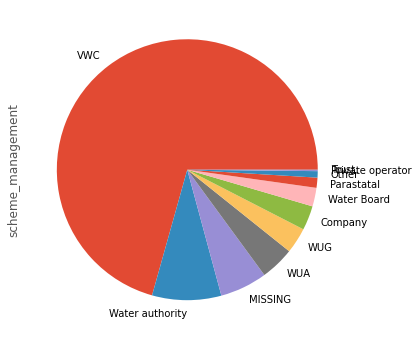

In [24]:
# relabel missing values
df['scheme_management'].fillna('MISSING', inplace=True)
# plot pie chart of the unique values for scheme_management with highest value counts
df.scheme_management.value_counts().plot.pie(subplots=True, figsize = (11,6), legend=False);

Here we see an opportunity to group some values together. Let's replace any value with lower counts than "Other" as "Other", and group the missing values as "Other" as well.

In [25]:
# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.scheme_management.value_counts().index:
    if len(df[df.scheme_management == val]) < len(df[df.scheme_management == 'Other']):
        other_vals.append(val)

# reset the values
df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x in other_vals else x)
# fill any missing values with 'Other'
df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x == 'MISSING' else x)

Let's look at how the wells perform in these categories.

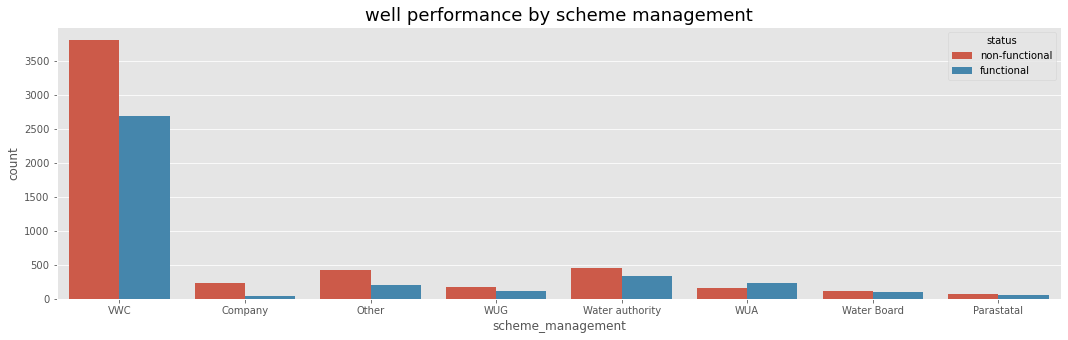

In [26]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='scheme_management', hue="status", data=df)
# title
ax.set_title('well performance by scheme management', size=18);

Let's look at the installer feature.

In [27]:
df.installer.value_counts().head(15)

DWE                        4309
Government                 1600
RWE                         649
District council            295
Commu                       278
Gover                       241
Centr                       162
Community                   159
District Council            150
Central govt                138
GOVER                       117
Central Government          110
Gove                         91
Central government           90
Region water Department      77
Name: installer, dtype: int64

This strongly indicates that some of the labels should be consolidated. We'll make those consolidations before we look at the value counts again.

In [28]:
df['installer'] = df['installer'].apply(
    lambda x: 'Government' if x in ['Gover', 'Centr', 'Central govt', 'Central govt', 'GOVER', 'Central Government',
                                    'Gove', 'Central government', 'Tanzania Government', 'GOVERNMENT', 'GOVERN',
                                   'Ce', 'Go', 'CENTRAL GOVERNMENT', 'central government', 'Cental Government',
                                   'Cebtral Government', 'Tanzanian Government', 'GOVERM', 'GOVERNME',
                                   'Centra govt', 'Cetral government /RC'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'District Council' if x in ['District council', 'Distri', 'DISTRICT COUNCIL',
                                          'Mbozi District Council', 'Council', 'District  Council'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'Community' if x in ['Commu', 'RWE /Community', 'RWE/Community', 'RWE/ Community', 'COMMU',
                                   'RWE Community', 'Communit', 'District Community j'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'DWE' if x in ['Dwe', 'DW'] else x)
df.installer.value_counts().head(15)

DWE                           4313
Government                    2726
RWE                            649
District Council               489
Community                      461
Region water Department         77
District Water Department       72
Sengerema Water Department      65
DDCA                            49
MUWASA                          28
WEDECO                          27
TCRS                            19
Mpang                           13
Handeni Trunk Main(             12
RW                              12
Name: installer, dtype: int64

Once again, this looks promising. Let's give the missing values a label and visualize with a pie chart again.

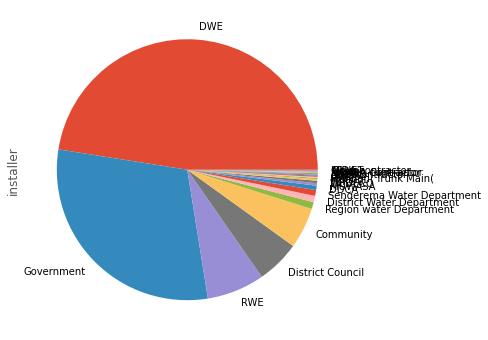

In [29]:
# relabel missing values
df['installer'].fillna('MISSING', inplace=True)
# plot pie chart of 25 unique values for installer with highest value counts
df.installer.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

Here again we can group anything with a value count smaller than that of Community as "other".

In [30]:
# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.installer.value_counts().index:
    if len(df[df.installer == val]) < len(df[df.installer == 'Community']):
        other_vals.append(val)

# reset the values
df['installer'] = df['installer'].apply(lambda x: 'Other' if x in other_vals else x)
# fill any missing values with 'Other'
df['installer'] = df['installer'].apply(lambda x: 'Other' if x == 'MISSING' else x)

Let's look at how the different installers affect well performance.

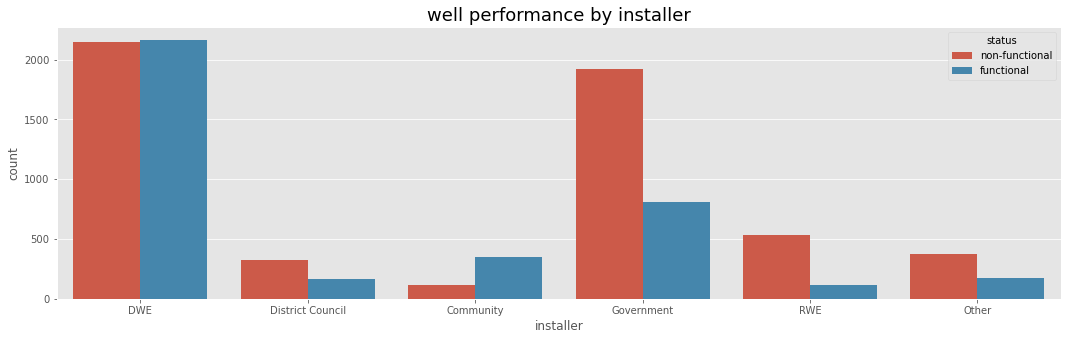

In [31]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='installer', hue="status", data=df)
# title
ax.set_title('well performance by installer', size=18);

The remaining features with missing values — public_meeting and permit — have only two unique values each. It could get a little trickier to impute anything here. Let's look at those values, starting with public_meeting.

In [32]:
df.public_meeting.value_counts()

True     7929
False     835
Name: public_meeting, dtype: int64

In [33]:
df.permit.value_counts()

True     6837
False    2304
Name: permit, dtype: int64

It's difficult to justify imputing anything here, even an "other" category, so for each of these features we'll have to either drop the feature or drop the records. The missing values for public_meeting are nearly 5% of the data, and we don't even know how helpful this feature will be yet, so it's safe to drop the column, since we the information gain we get from that column is not worth losing 5% of our records.

In [34]:
df.drop(columns='public_meeting', inplace=True)
# show row and column counts
df.shape

(9182, 39)

There are fewer missing values for the permit feature — only about half of a percent — so it's tempting to just drop those records and keep the feature. It would be nice to know whether this feature might matter.

And because we'll likely run into this question again (of whether a feature will even matter), we'll create a function that can help answer that question for us.

In [35]:
# create a function that compares functionality success
def compare_vals(feature, vals):
    # loop over all the values in a set of values
    for val in vals:
        # define the numerator as the number of functional records
        num = len(df[(df[feature] == val) & (df['target'] == 0)])
        # define the denominator
        denom = len(df[df[feature] == val])
        # report the percentage
        print(val, "%.0f%%" % (100 * num / denom))

In [36]:
compare_vals('permit', [True, False])

True 41%
False 41%


This shows that 41% of wells *with* permits are functional, and 41% of wells *without* permits are functional. Now we know for sure that this feature is truly useless and can safely drop it.

In [37]:
df.drop(columns='permit', inplace=True)
# show row and column counts
df.shape

(9182, 38)

## Administrative features
The id, date_recorded, and recorded_by features won't help with any of our analysis. We can safely drop them.

In [38]:
df.drop(columns=['id', 'date_recorded', 'recorded_by'], inplace=True)
# show row and column counts
df.shape

(9182, 35)

## Numerical features with potentially false zeros

We've tackled all the missing values now, but sometimes values of zero are entered when the value is actually missing.

Let's explore the numerical features and find how many zero values each feature has and what percentage of its values are zero.

In [39]:
for col in df.select_dtypes(include=['number']).columns:
    count = df[col][abs(df[col]) == 0].count()
    pct = round(100*count/(len(df)),2)
    print(col, (19-len(col))*' ', count, (5-len(str(count)))*' ', pct, '%')

amount_tsh           7096   77.28 %
gps_height           2599   28.31 %
longitude            234    2.55 %
latitude             0      0.0 %
num_private          9041   98.46 %
region_code          0      0.0 %
district_code        0      0.0 %
population           2841   30.94 %
construction_year    2710   29.51 %
elevation            280    3.05 %
target               3766   41.02 %


For each of these, we'll consider whether the zeros are "real" and what to do about them if they are not.

### Region code and district code

First, it would seem that region_code and district_code are actually *categorical* variables, not numerical. Let's look at a sample of those values and see how many unique values there are for each.

In [40]:
# show some values for region and district codes
df[['region_code', 'district_code']].head(10)

region_code  district_code
25            3              4
28            3              1
32            3              4
39           16              1
41           11              3
44            2              2
53           19              6
59           18              2
61            4              1
67           18              1

In [41]:
# show how many unique values there are for each feature
df[['region_code', 'district_code']].nunique()

region_code      23
district_code    15
dtype: int64

There's nothing to suggest that region and district codes should be regarded as numerical. We'll convert them to string objects and later apply one-hot encoding to these features.

In [42]:
# convert region_code to string object
df['region_code'] = df['region_code'].astype('object')
# convert district_code to string object
df['district_code'] = df['district_code'].astype('object')

### Num_private

Next, nearly 99% of the records have a zero value for the num_private column, and further, the documentation gives no explanation at all of what num_private is. We'll drop this feature.

In [43]:
# drop num_private
df.drop(columns='num_private', inplace=True)
# show row and column counts
df.shape

(9182, 34)

### Construction Year

Let's sample the construction_year values.

In [44]:
# show some values for construction year
df.construction_year.value_counts().head()

0       2710
1972     514
1974     415
2010     322
1976     279
Name: construction_year, dtype: int64

As expected, these zero values make no sense. There's no way to impute the actual values for this feature, and roughly *one third* of the records have missing values in this column, so we'll have to drop that feature.

That's unfortunate, because this feature could potentially have been helpful. But we just can't justify guessing at one third of the values and pretending the result is somehow meaningful.

Before we delete this feature, let's try to learn what we can from the nonzero values. Here we'll make a line graph of performance percentage by half-decade.

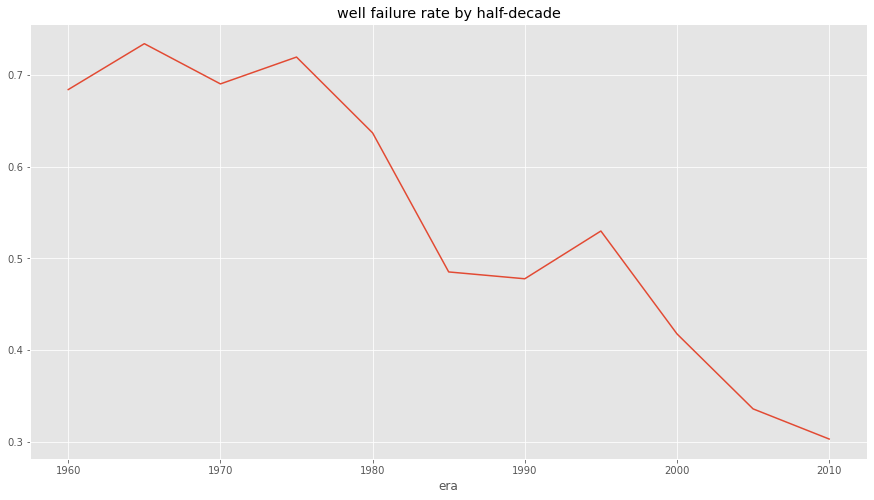

In [45]:
df['era'] = (df['construction_year'] // 5) * 5
df[df.construction_year > 0].groupby('era').mean()['target'].plot(
    figsize=(15,8), title='well failure rate by half-decade');
df.drop(columns='era', inplace=True)

It certainly looks like more recently installed wells perform better (fail less).

In [46]:
# drop construction_year
df.drop(columns=['construction_year'], inplace=True)
# show row and column counts
df.shape

(9182, 33)

### Longitude and latitude

Easily available maps online show that locations within Tanzania's boundaries should have longitude values roughly between 29 and 40, so the zero values for longitude are certainly false.

Latitude values should be roughly between -1 and -11.

Let's look at a histogram of the *non*-zero longitudes and *all* the latitudes to confirm what we have.

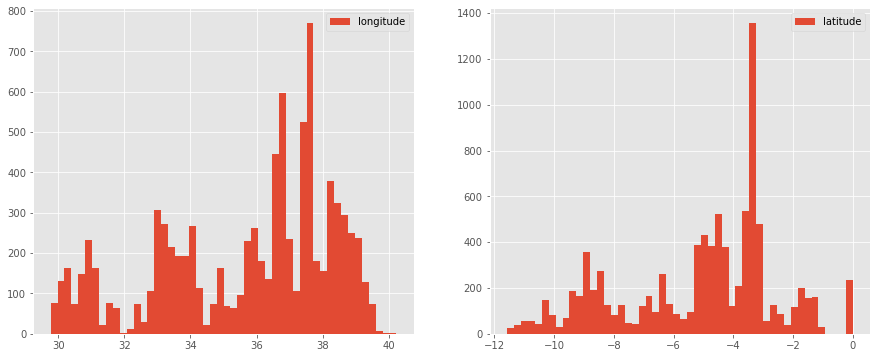

In [47]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,6))
# plot histogram of nonzero longitudes
df[df.longitude != 0].longitude.hist(bins=50, ax=ax1, legend=True)
# plot histogram of all latitudes
df.latitude.hist(bins=50, ax=ax2, legend=True);

The nonzero longitudes check out fine, but there seem to be some *near*-zero latitudes. Let's take a closer look at these values. Specifically, let's look at the *longitude* values for these near-zero *latitudes*.

In [48]:
# show longitude values for near-zero latitude records
df[df.latitude > -.2].longitude.describe()

count    234.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: longitude, dtype: float64

Just as expected, these near-zero latitude values are for the exact same (234) records that have zero longitude values.

The thing is, we will ultimately drop these two features before modeling anyway, because lat/long are not true numerical features, i.e. 20° of longitude compared to 10° of longitude does not represent *twice as much* of anything. These features were only ever going to help us plot and understand some of the other features. This just means that we'll have to omit those records when we make those plots.

Now that we know which lat/long values we can use, let's generate a map that shows where wells are functional and non-functional

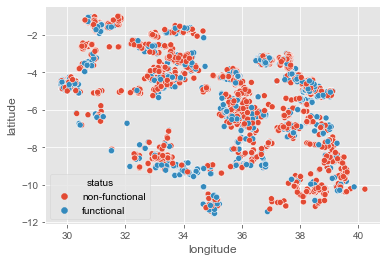

In [49]:
sns.scatterplot(x="longitude", y="latitude",
                hue="status",
                data=df[df.longitude != 0]
               )

sns.set(rc={'figure.figsize':(10,8)});

(Non-)functionality doesn't appear to dominate in any general geographical area. Functional wells are regularly interspersed with non-functional wells.

### GPS height (altitude)

Next let's investigate gps_height. Since Tanzania has a coastline along the Indian Ocean, it's plausible that some locations are in fact at zero elevation. Let's use the (nonzero) lat/long values to explore this.

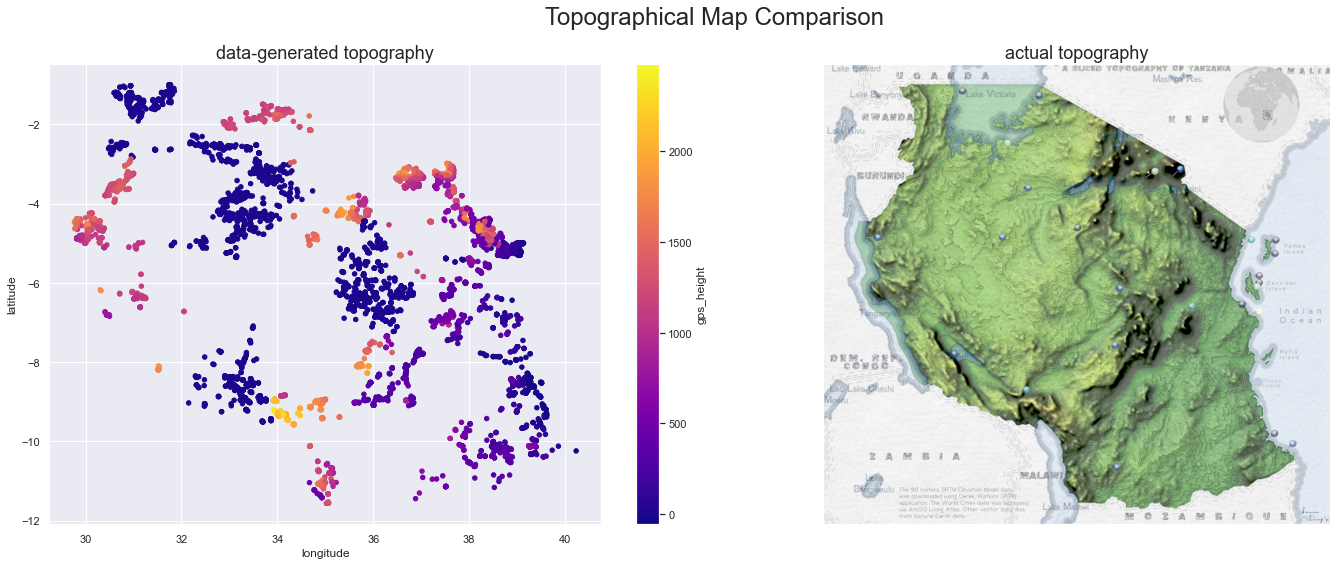

In [50]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat for nonzero longs with color gradient for elevation
df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='gps_height', cmap='plasma', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# titles
fig.suptitle('Topographical Map Comparison', size=24)
ax1.set_title('data-generated topography', size=18)
ax2.set_title('actual topography', size=18)
fig.tight_layout();

The data-generated plot on the left indicates that there are lower elevations near the coastline, but there are also many lower elevations in inland areas. A cursory comparison against the actual topographical map on the right suggests those inland areas probably can't be that low, but let's look at a scatterplot of which records are *exactly* zero.

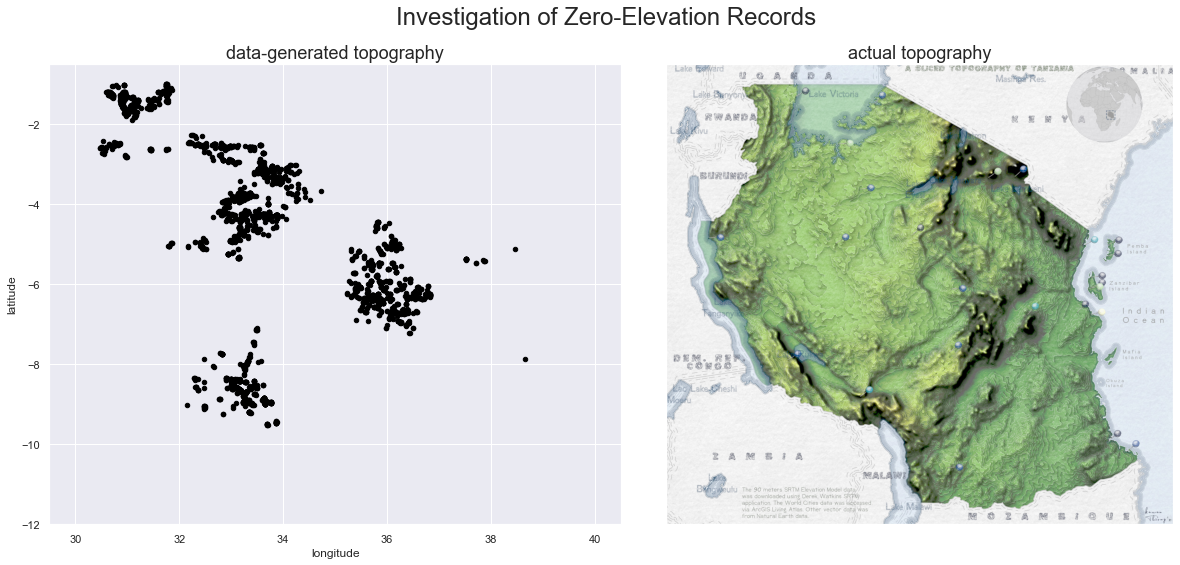

In [51]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(17,8))
# plot long/lat of *only* zero elevation records
df[(df.longitude > 0) & (df['gps_height'] == 0)].plot.scatter(
    x='longitude', y='latitude', c = 'black', ax=ax1)
# set the axis ranges to match the ones in the previous plot
ax1.set_xlim([29.5, 40.5])
ax1.set_ylim([-12, -0.5])
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Investigation of Zero-Elevation Records', size=24)
ax1.set_title('data-generated topography', size=18)
ax2.set_title('actual topography', size=18)
fig.tight_layout();

We theorized that *some* locations could actually have zero elevation, especially if they were along the ocean coastline, but it didn't even turn out that way — the zero-elevation locations are, except for a tiny fraction of them, *all* inland locations. These locations can't possibly (all) have an elevation of (exactly) zero.

In a separate notebook, we were able to implement some api requests to Google to retrieve elevation values for records which we have positional coordinates for. This column with values from Google has the title "elevation".

Unfortunately, a closer look reveals that we won't be able to use either of these features ("gps_height" or "elevation"). If we compare records for which we DO have gps_height values, the elevation values (from Google) are rarely equal. Here is a histogram of the difference between the values:

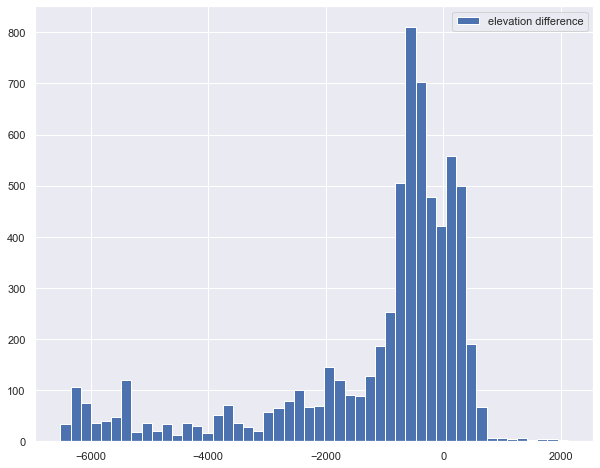

In [52]:
# create new column of elevation differences
df['elevation difference'] = df['elevation'] - df['gps_height']
# plot a histogram of these differences
df[(df.gps_height != 0)]['elevation difference'].hist(bins=50,legend=True)
# drop the column we created
df.drop(columns='elevation difference', inplace=True);

While many differences are close to zero, relatively few are exactly zero, and many differences are way too large.

We could explore whether a sign error were responsible for the differences by making a similar histogram using absolute values of each feature:

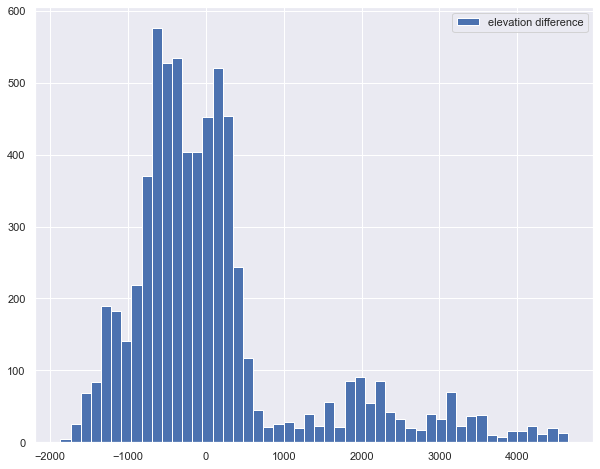

In [53]:
# create new column of differences of absolute values of elevations
df['elevation difference'] = abs(df['elevation']) - abs(df['gps_height'])
# plot a histogram of these differences
df[(df.gps_height != 0)]['elevation difference'].hist(bins=50,legend=True)
# drop the column we created
df.drop(columns='elevation difference', inplace=True);

This isn't much better.

We can also explore whether a unit difference (e.g. feet v. meters) is responsible for the differences by examining the ratios of the values. In the case of 3.28 feet = 1 meter, we should expect to see a spike around this value or its reciprocal, 0.30:

In [54]:
# create new column of (absolute values of) ratios of elevations
df['elevation ratio'] = df.apply(
    lambda x: 0 if x.gps_height == 0 else round(abs(x.elevation / x.gps_height), 2), axis=1)
# show common values for this ratio
print(df['elevation ratio'].value_counts().head(10))
# drop the column we created
df.drop(columns='elevation ratio', inplace=True);

0.00    2624
0.48      91
0.46      89
0.52      80
0.54      80
0.55      75
0.49      71
0.56      70
0.53      70
0.66      69
Name: elevation ratio, dtype: int64


None of the most common values are near enough to either target, 3.28 or 0.30, for us to assume this is a unit error (feet v. meters). Nor do those values seem to cluster around any other ratio that would help us make sense of the discrepancy.

If we simply concluded that the gps_height values were to blame, then the elevation values from Google should at least make sense by themselves. Let's make another map and see:

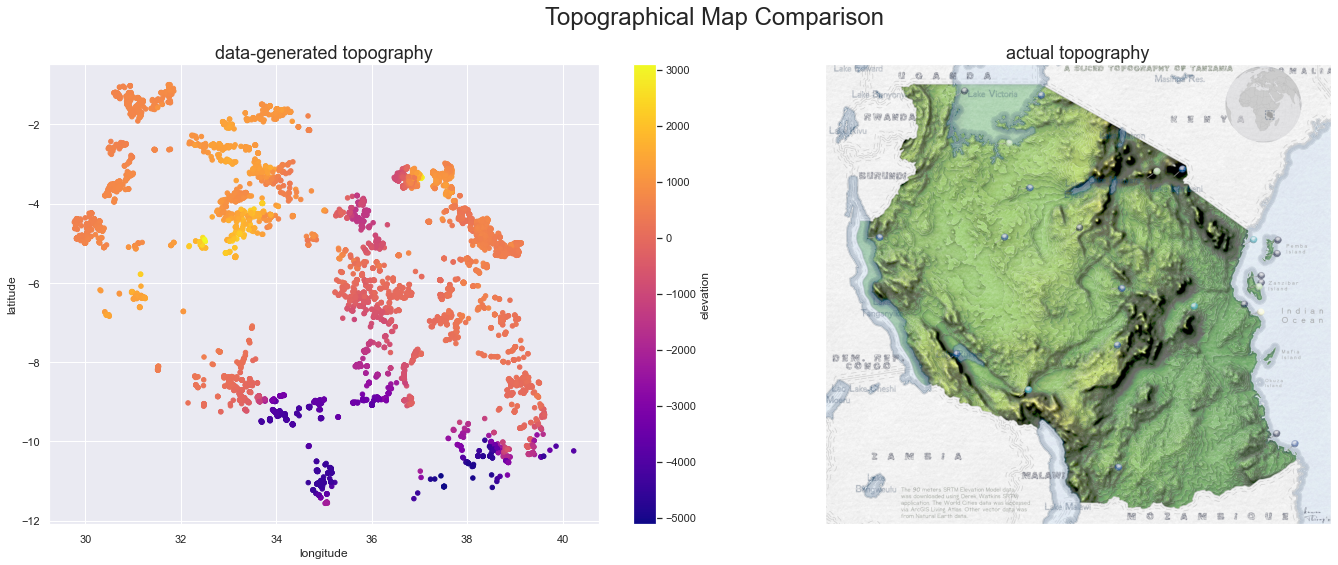

In [55]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat for nonzero longs with color gradient for elevation
df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='elevation', cmap='plasma', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# titles
fig.suptitle('Topographical Map Comparison', size=24)
ax1.set_title('data-generated topography', size=18)
ax2.set_title('actual topography', size=18)
fig.tight_layout();

Here we see just how many of the values are negative (and too extreme to be real). Our last hope for this feature is if this is only a sign error. Let's try it one more time using absolute values for this feature:

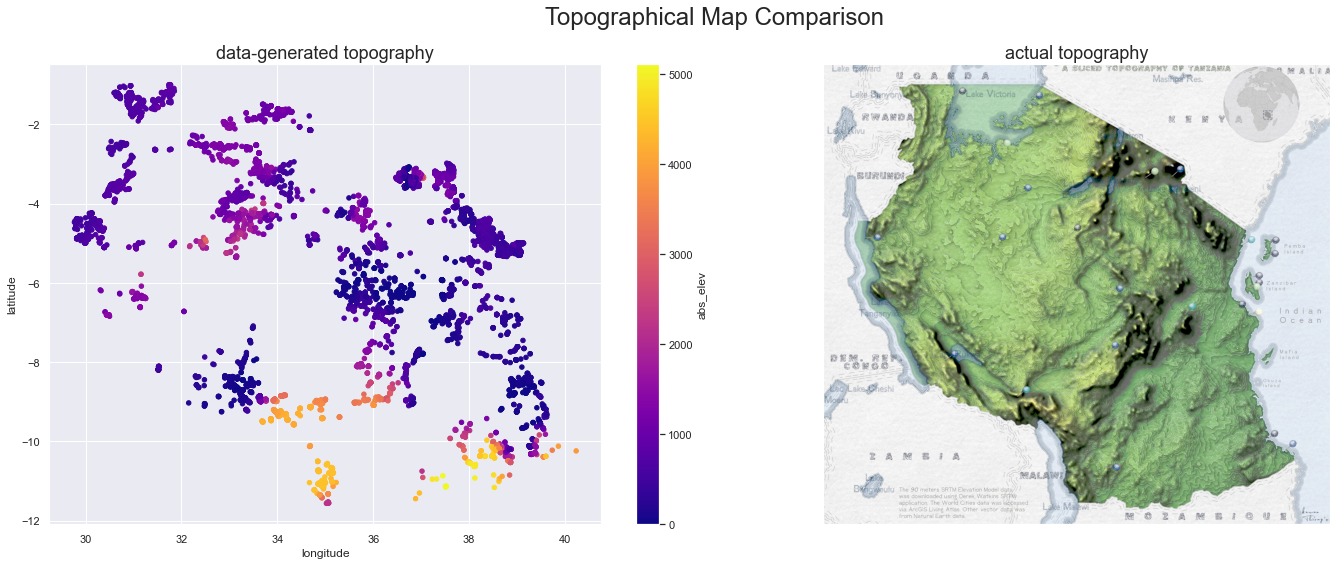

In [56]:
# create new feature for single use
df['abs_elev'] = abs(df['elevation'])
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat for nonzero longs with color gradient for elevation
df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='abs_elev', cmap='plasma', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# titles
fig.suptitle('Topographical Map Comparison', size=24)
ax1.set_title('data-generated topography', size=18)
ax2.set_title('actual topography', size=18)
fig.tight_layout()
# drop the column we created
df.drop(columns='abs_elev', inplace=True);

This definitely doesn't look right either. We'll have to drop both the gps_height and elevation columns.

In [57]:
# drop gps_height and elevation
df.drop(columns=['gps_height', 'elevation'], inplace=True)
# show row and column counts
df.shape

(9182, 31)

### Population

The next feature with zero values to explore is population. Let's use another scatterplot map to get a better understanding of this feature.

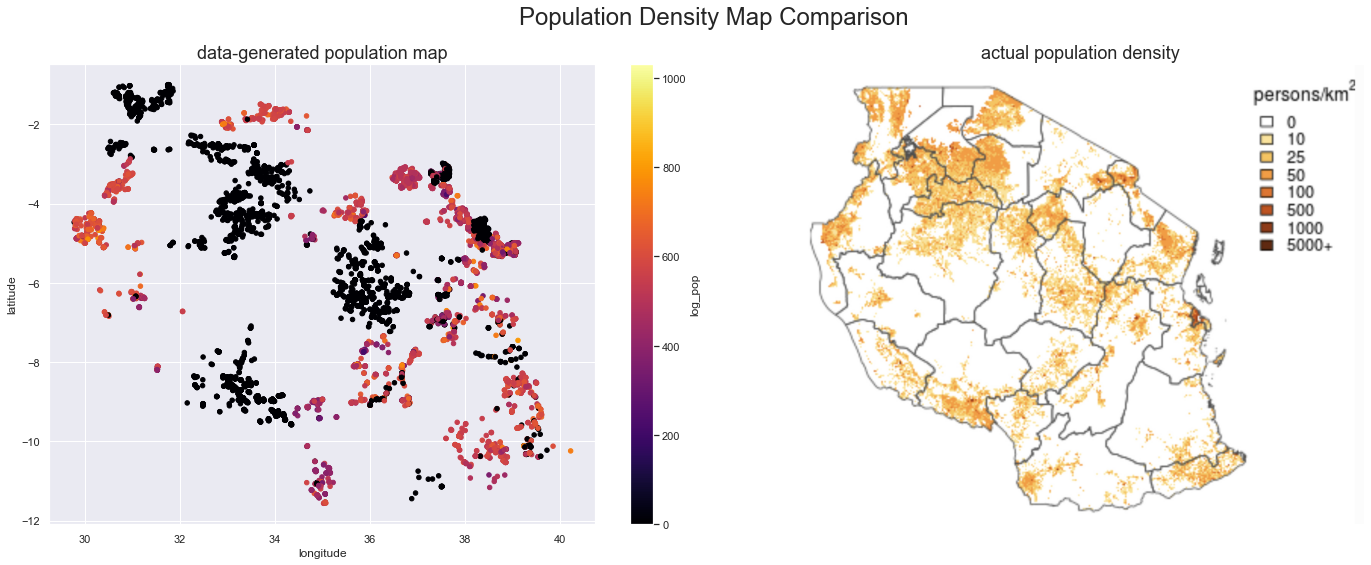

In [58]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# create a temporary feature that calculates the logarithm of the population
df['log_pop'] = df.population.apply(lambda x: 0 if x <= 1 else int(np.log(x)*100))
# plot long/lat for nonzero longs with color gradient for population

df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='log_pop', cmap='inferno', ax=ax1);
# drop the log_pop column that was created
df.drop(columns='log_pop', inplace=True)
# upload an image
im = plt.imread("../images/pop_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Population Density Map Comparison', size=24)
ax1.set_title('data-generated population map', size=18)
ax2.set_title('actual population density', size=18)
fig.tight_layout();

(We've calculated logarithm values of the population records in order to better distinguish the population values from each other.)

On the left, we've plotted populations that are served by the government wells. On the right, for comparison, is a presumably accurate population density map of Tanzania from the UC Davis website (https://gfc.ucdavis.edu/profiles/rst/tza.html).

For one thing, we can see that there are water wells in pretty much all the same locations where there are people, which is good! However, our data suggests that there *aren't* any people at the locations in black. That is *not* consistent with the population density map on the right. As these zero values, again, constitute roughly a third of the records, it looks like we'll have to drop the population feature, too, since it would be too costly to drop those records.

It's not likely that knowing the population in a given area would have factored into explaining whether their wells were functioning, so dropping this feature probably isn't such a great loss.

In [59]:
# drop population
df.drop(columns='population', inplace=True)
# show row and column counts
df.shape

(9182, 30)

### Total static head

The last remaining zero value is for amount_tsh or "total static head". The documentation doesn't do much to clarify this term, but simple search results (e.g. https://www.rfmacdonald.com/documents/Goulds-Centrifugal%20Pump%20Fundamentals.pdf) reveal that the term refers to the vertical distance between the source water level and the level at which the water is accessed. As far as we know, it's quite plausible indeed for this value to be zero, so we'll leave it. In fact, one site (https://www.linkedin.com/pulse/understanding-chilled-water-pump-head-muneer-ahamed-shaik/) describes "closed loop systems", which by definition have zero total static head.

Let's try to understand just how predictive this feature is. First, let's calculate the functional success rates for zero and nonzero tsh.

In [60]:
# the code below is a tweak on the compare_val function
# calculate numerator for zero tsh
num = len(df[(df['amount_tsh'] == 0) & (df['target'] == 0)])
# calculate denominator for zero tsh
denom = len(df[df['amount_tsh'] == 0])
# print as a percentage
print('ZERO tsh:', "%.0f%%" % (100 * num / denom))
# calculate numerator for nonzero tsh
num = len(df[(df['amount_tsh'] != 0) & (df['target'] == 0)])
# calculate denominator for nonzero tsh
denom = len(df[df['amount_tsh'] != 0])
# print as a percentage
print('NONZERO tsh:', "%.0f%%" % (100 * num / denom))

ZERO tsh: 34%
NONZERO tsh: 63%


So among the supposed "closed loop systems", the well performance is significantly worse than systems with positive values for total static head. (Or are we really just finding that wells perform worse in cases where tsh is *not actually known*?)

The more than 2,000 nonzero tsh values are tricky to explore because they are not distributed uniformly, and there are many repeated values. We'll create and reorder a new dataframe of just these values and then make a "success rate" line graph.

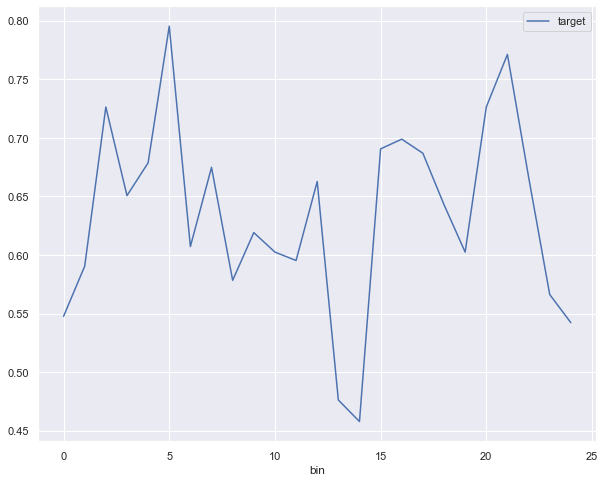

In [61]:
# create dataframe of only nonzero tsh records and their target values
df_tsh = df[df['amount_tsh'] != 0][['amount_tsh', 'target']].sort_values(
    'amount_tsh', ascending=True).reset_index()
# drop old index column and create new one
df_tsh.drop(columns='index', inplace=True)
df_tsh['bin'] = df_tsh.index
# set number of bins
bins = 25
# recalculate bin number according to percentile (or decile, etc. according to number of bins)
df_tsh['bin'] = df_tsh['bin'].apply(lambda x: bins * x // len(df_tsh))
# merge values to make dataframe of only relevant values
df_tsh_hist = 1 - df_tsh.groupby('bin').mean()[['target']]
df_tsh_hist.plot();

This does not shed much light on the predictive nature of total static head.

*Note: In an earlier iteration of this notebook, we ran all the models with and without this feature and found that models performed almost unilaterally better **without** the feature.*

We'll drop this feature.

In [62]:
# drop total static head
df.drop(columns='amount_tsh', inplace=True)
# show row and column counts
df.shape

(9182, 29)

## Features with large numbers of unique values

Let's look at other categorical features with too many unique values to factor into our analysis.

In [63]:
df.select_dtypes(include='object').loc[
    :, df.select_dtypes(include='object').apply(lambda x: x.nunique()) > 10].nunique()

wpt_name                 6529
region                     20
region_code                23
district_code              15
lga                        81
ward                      901
extraction_type            17
extraction_type_group      13
management                 11
dtype: int64

### Waterpoint name, Ward, and LGA

We'll investigate wpt_name, ward, and lga using the pie chart method we used earlier.

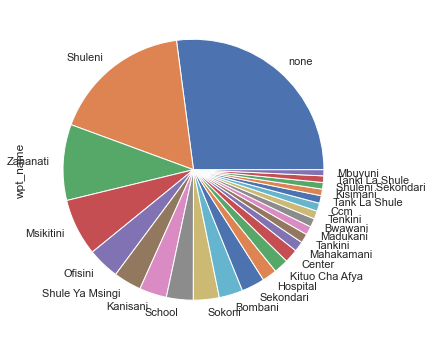

In [64]:
# plot pie chart of 25 unique values for wpt_name with highest value counts
df.wpt_name.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

We see that the largest number of these values are actually missing, and the rest are rather evenly distributed, so we can safely drop them.

In [65]:
df.drop(columns='wpt_name', inplace=True)
# show row and column counts
df.shape

(9182, 28)

Here's the pie chart for the ward feature.

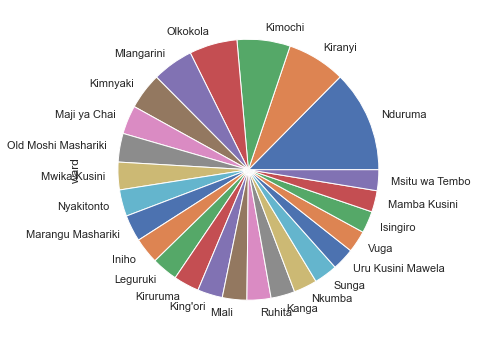

In [66]:
# plot pie chart of 25 unique values for ward with highest value counts
df.ward.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

There's no apparent way to group these into anything useable. We'll drop it.

In [67]:
df.drop(columns='ward', inplace=True)
# show row and column counts
df.shape

(9182, 27)

Here's the pie chart for the lga feature.

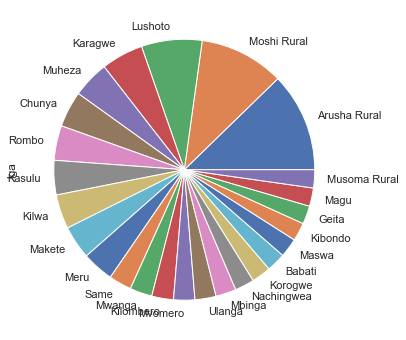

In [68]:
# plot pie chart of 25 unique values for lga with highest value counts
df.lga.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

This will have to go as well.

In [69]:
df.drop(columns='lga', inplace=True)
# show row and column counts
df.shape

(9182, 26)

The three features we just dropped were all geographical identifiers. It's not clear whether that kind of feature would be useful in our modeling or not.

## Geographical identifiers

These features serve as geographical identifiers: basin, region, region_code, and district_code. There is likely to be some redundancy among these features, and we should generally try to understand them better.

We'll start by plotting all of the basins.

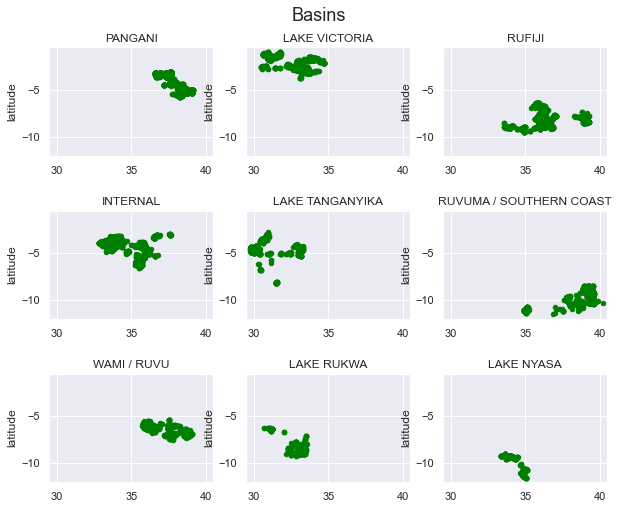

In [70]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Basins", fontsize=18, y=0.95)

# loop through basins and axes
for basin, ax in zip(df.basin.value_counts().index, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[df['basin'] == basin].plot.scatter(x='longitude', y='latitude', c='green', ax=ax)

    # chart formatting
    ax.set_title(basin.upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

Each basin appears to be roughly contiguous and generally separate from other basins, which looks good.

Let's look at how the basins fit together.

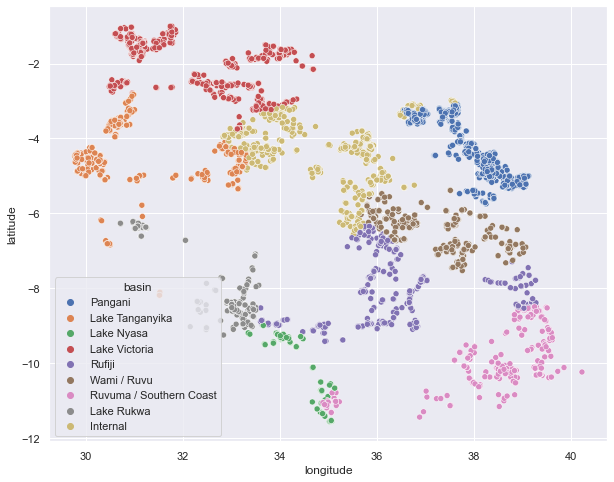

In [71]:
sns.scatterplot(x="longitude", y="latitude",
                hue="basin",
                data=df[df.longitude != 0]
               )

sns.set(rc={'figure.figsize':(15,12)});

Let's take a look at how the wells performed in each basin.

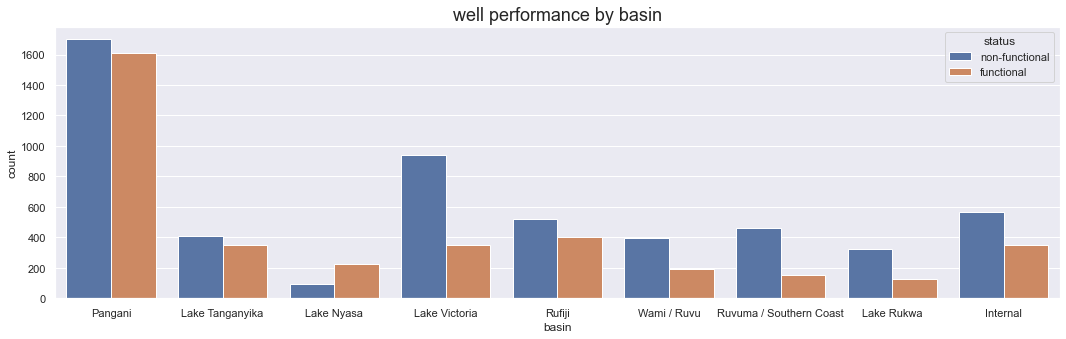

In [72]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='basin', hue="status", data=df)
# title
ax.set_title('well performance by basin', size=18);

The Pangani basin has the most non-functional wells. The Lake Victoria basin and the Southern Coast basin perform worst by percentage.

Let's explore the same for district codes.

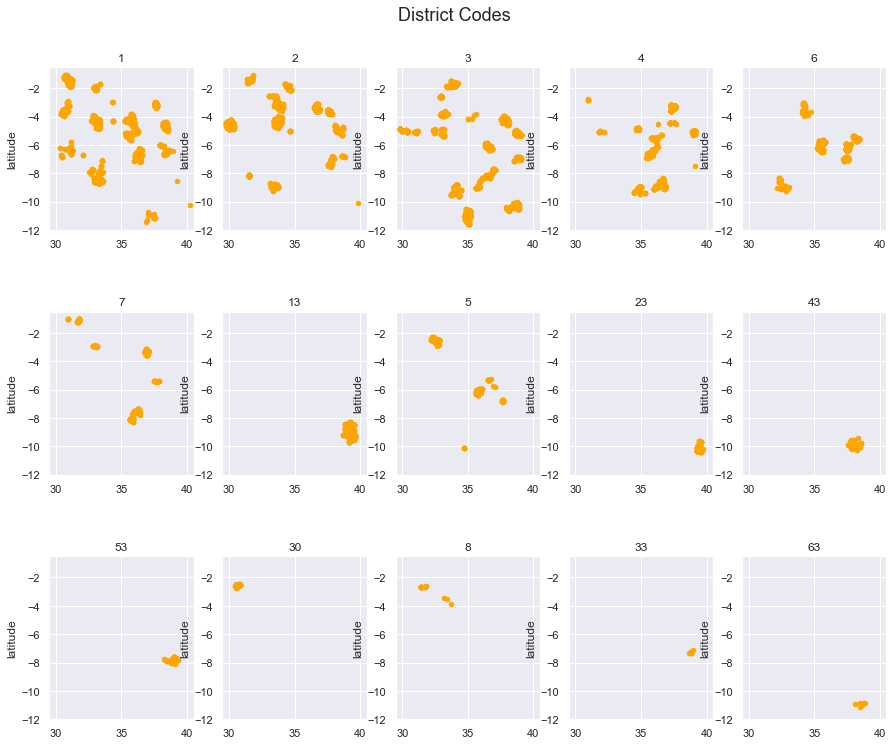

In [73]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("District Codes", fontsize=18, y=0.95)

# loop through basins and axes
for code, ax in zip(df.district_code.value_counts().index, axs.ravel()):
    # filter df for district code and plot on specified axes
    df[df['district_code'] == code].plot.scatter(x='longitude', y='latitude', c='orange', ax=ax)

    # chart formatting
    ax.set_title(str(code).upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

The first several "districts" seem to overlap a great deal. Since we can't make proper sense of this feature, we'll drop it.

In [74]:
df.drop(columns='district_code', inplace=True)
# show row and column counts
df.shape

(9182, 25)

Next, we'll look at the region feature.

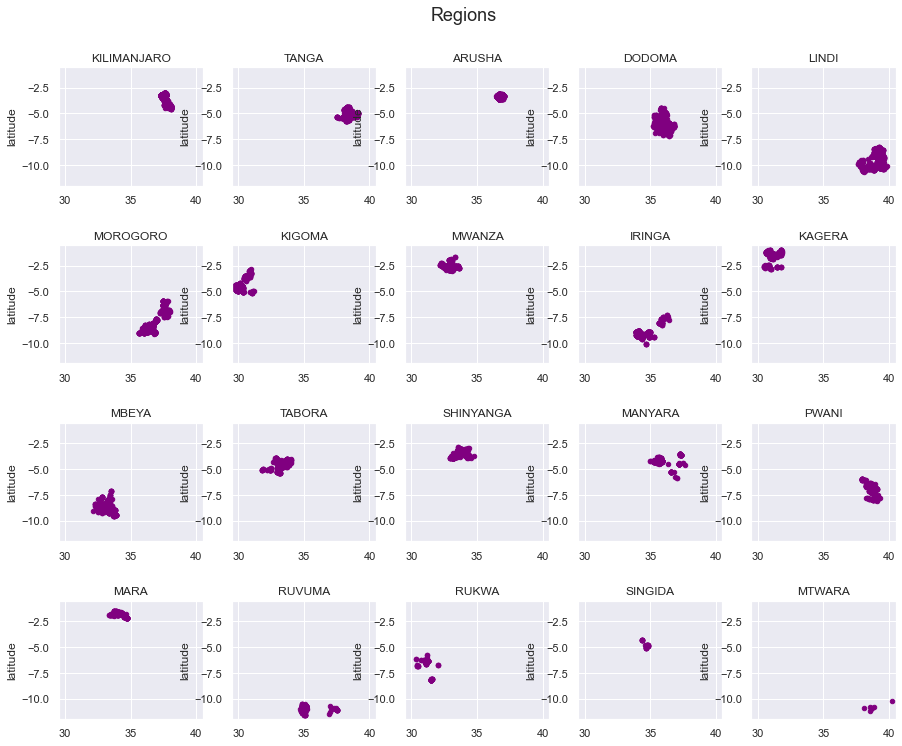

In [75]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Regions", fontsize=18, y=0.95)

# loop through regions and axes
for region, ax in zip(df.region.value_counts().index, axs.ravel()):
    # filter df for region and plot on specified axes
    df[df['region'] == region].plot.scatter(x='longitude', y='latitude', c='purple', ax=ax)

    # chart formatting
    ax.set_title(region.upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

These also appear to be contiguous and separate regions.

Let's look at how the regions fit together.

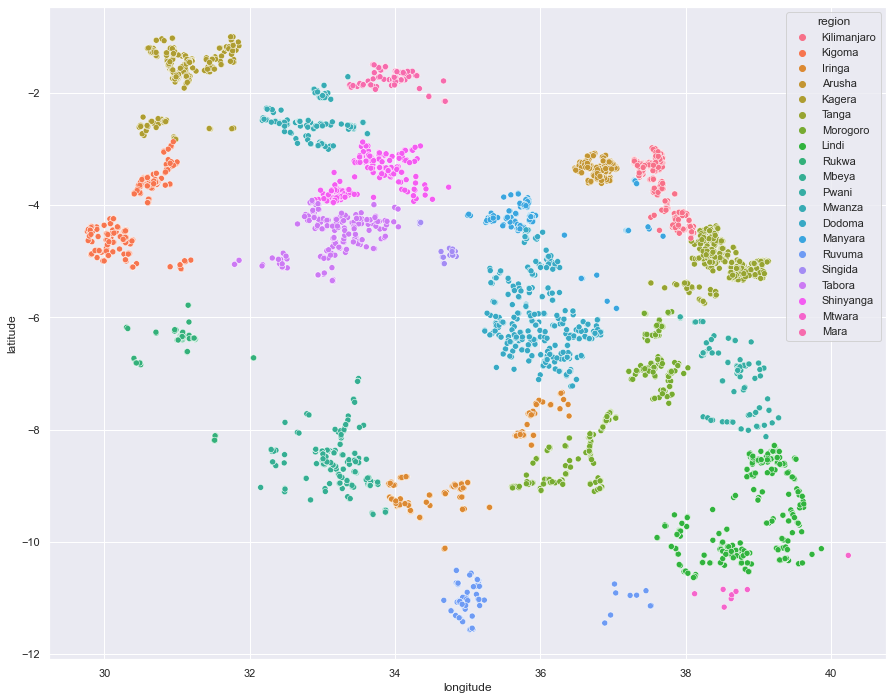

In [76]:
sns.scatterplot(x="longitude", y="latitude",
                hue="region",
                data=df[df.longitude != 0]
               )

sns.set(rc={'figure.figsize':(15,12)});

Let's take a look at how the wells performed in each region.

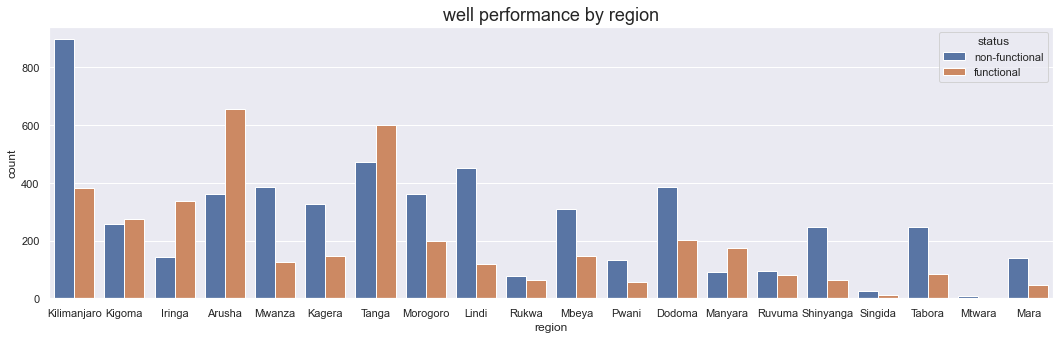

In [77]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='region', hue="status", data=df)
# title
ax.set_title('well performance by region', size=18);

There was a variety of performance levels among the 20 regions.

To recap our geographical identifiers, we already dropped, "ward", "subvillage", "lga", and "wpt_name", and we have now dropped "district code" (and will soon drop region code), leaving just basin and region.

It would seem that "basin" is a natural distinction (a description of natural land features), whereas "region" is man-made (imposed by governing bodies). It may be interesting to note which of these ultimately proves more meaningful.

## Possibly redundant features

Several features seem to be related, such as waterpoint_type and waterpoint_type_group. In such cases, we would generally prefer to keep the one with fewer unique values and drop the other(s). Let's look at value counts for groups of features that seem to be related.

To help in this part of the exploration, we'll often employ the `compare_vals` function we created much earlier to help us determine how certain values of a feature affect the target feature, i.e. whether those values serve a useful distinction or they should be lumped together.

### region / code

In [78]:
df[['region_code', 'region']].value_counts()

region_code  region     
3            Kilimanjaro    1280
4            Tanga          1072
2            Arusha         1017
1            Dodoma          589
5            Morogoro        562
16           Kigoma          533
19           Mwanza          513
11           Iringa          478
18           Kagera          474
12           Mbeya           457
80           Lindi           418
14           Tabora          332
17           Shinyanga       309
21           Manyara         265
20           Mara            185
10           Ruvuma          176
8            Lindi           151
15           Rukwa           138
6            Pwani           130
60           Pwani            59
13           Singida          34
90           Mtwara            7
18           Lindi             2
99           Mtwara            1
dtype: int64

There are only a *very* few repetitions of regions with different code numbers here. We'll keep "region", since there are fewer of them, and we'll drop "region code".

In [79]:
df.drop(columns='region_code', inplace=True)
# show row and column counts
df.shape

(9182, 24)


### Extraction type / group / class

In [80]:
df[['extraction_type', 'extraction_type_group']].value_counts()

extraction_type            extraction_type_group
gravity                    gravity                  5591
other                      other                     858
mono                       mono                      666
submersible                submersible               568
nira/tanira                nira/tanira               490
ksb                        submersible               301
swn 80                     swn 80                    282
india mark ii              india mark ii             190
afridev                    afridev                   130
other - rope pump          rope pump                  28
other - swn 81             other handpump             28
climax                     other motorpump            21
windmill                   wind-powered               14
india mark iii             india mark iii              5
cemo                       other motorpump             5
other - play pump          other handpump              4
other - mkulima/shinyanga  other handpu

The only significant consolidation done here is the types "submersible" and "ksb" get consolidated into the group "submersible". Let's see how distinct these types are.

In [81]:
compare_vals('extraction_type', ['submersible', 'ksb'])

submersible 48%
ksb 6%


This shows that a far greater percentage "submersible" waterpoints are functional than are the waterpoints of "ksb" extraction type. Our choice (to drop one of two similar columns) involves consolidating these two values into one category or preserving the distinction. Since the percentage difference here seems so significant, it may make the most sense to perserve this distinction. As for the remaining values, we we can just consolidate everything with a group size smaller than "afridev" into the "other" group.

In [82]:
# reassign values in the "submersible" group
df['extraction_type_group'] = df.apply(
    lambda x: 'ksb' if x.extraction_type == 'ksb' else x.extraction_type_group, axis=1)

# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.extraction_type_group.value_counts().index:
    if len(df[df.extraction_type_group == val]) < len(df[df.extraction_type_group == 'afridev']):
        other_vals.append(val)

# reset the values
df['extraction_type_group'] = df['extraction_type_group'].apply(lambda x: 'other' if x in other_vals else x)

Having edited the extraction group, we can drop the extraction type feature.

In [83]:
df.drop(columns='extraction_type', inplace=True)
# show row and column counts
df.shape

(9182, 23)

Now we need to further consider which feature to keep between extraction type "group" and "class". We'll look at the value counts.

In [84]:
df[['extraction_type_group', 'extraction_type_class']].value_counts()

extraction_type_group  extraction_type_class
gravity                gravity                  5591
other                  other                     858
mono                   motorpump                 666
submersible            submersible               568
nira/tanira            handpump                  490
ksb                    submersible               301
swn 80                 handpump                  282
india mark ii          handpump                  190
afridev                handpump                  130
other                  handpump                   38
                       rope pump                  28
                       motorpump                  26
                       wind-powered               14
dtype: int64

We may explore this more in depth later or change our minds during modeling, but for now we'll keep the feature with fewer unique values and drop the other.

In [85]:
df.drop(columns='extraction_type_group', inplace=True)
# show row and column counts
df.shape

(9182, 22)

### Management / group

In [86]:
df[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          7242
wua               user-group           380
water board       user-group           362
wug               user-group           322
company           commercial           258
water authority   commercial           182
other             other                171
parastatal        parastatal           129
private operator  commercial            69
unknown           unknown               65
trust             commercial             2
dtype: int64

Based on the value counts, it seems best to keep the different user-groups but consolidate the rest into "commercial" and "other".

In [87]:
# reassign values
df['management'] = df.apply(
    lambda x: 'commercial' if x.management_group == 'commercial' else x.management, axis=1)

# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.management.value_counts().index:
    if len(df[df.management == val]) < len(df[df.management == 'wug']):
        other_vals.append(val)

# reset the values
df['management'] = df['management'].apply(lambda x: 'other' if x in other_vals else x)

Then we can drop the other feature.

In [88]:
df.drop(columns='management_group', inplace=True)
# show row and column counts
df.shape

(9182, 21)

### payment / type

In [89]:
df[['payment', 'payment_type']].value_counts()

payment                payment_type
never pay              never pay       4766
unknown                unknown         1220
pay monthly            monthly         1216
pay per bucket         per bucket      1187
pay when scheme fails  on failure       366
pay annually           annually         296
other                  other            131
dtype: int64

These are in a precise one-to-one correspondence (they're just named differently), so one of them can be dropped without question. Also, we might as well merge "unknown" with "other".

In [90]:
df.drop(columns='payment_type', inplace=True)
df['payment'] = df['payment'].apply(lambda x: 'other' if x == 'unknown' else x)
# show row and column counts
df.shape

(9182, 20)

### Water quality / group

In [91]:
df[['water_quality', 'quality_group']].value_counts()

water_quality       quality_group
soft                good             8117
salty               salty             637
unknown             unknown           298
fluoride            fluoride           44
milky               milky              36
coloured            colored            27
salty abandoned     salty              19
fluoride abandoned  fluoride            4
dtype: int64

Most of the values here seem too small to matter, so we'll keep the feature that's more consolidated and drop "water quality".

In [92]:
df.drop(columns='water_quality', inplace=True)
# show row and column counts
df.shape

(9182, 19)

### Water quantity / group

In [93]:
df[['quantity', 'quantity_group']].value_counts()

quantity      quantity_group
enough        enough            4738
insufficient  insufficient      3050
dry           dry                983
seasonal      seasonal           316
unknown       unknown             95
dtype: int64

This is another one-to-one match, so we can just drop one of them.

In [94]:
df.drop(columns='quantity_group', inplace=True)
# show row and column counts
df.shape

(9182, 18)

### source / type / class

In [95]:
df[['source', 'source_type']].value_counts()

source                source_type         
spring                spring                  4028
machine dbh           borehole                1494
river                 river/lake              1399
shallow well          shallow well            1365
lake                  river/lake               321
rainwater harvesting  rainwater harvesting     252
dam                   dam                      243
hand dtw              borehole                  51
other                 other                     18
unknown               other                     11
dtype: int64

The only distinctions between source and source_type are that "source" recognizes two values for each of borehole, river/lake, and other. In every case, at least one of the value counts is small enough that there doesn't seem to be any harm in consolidating, so we'll keep "source type" and drop "source".

In [96]:
df.drop(columns='source', inplace=True)
# show row and column counts
df.shape

(9182, 17)

Let's consider the distinctions between source type and source class

In [97]:
df[['source_type', 'source_class']].value_counts()

source_type           source_class
spring                groundwater     4028
river/lake            surface         1720
borehole              groundwater     1545
shallow well          groundwater     1365
rainwater harvesting  surface          252
dam                   surface          243
other                 unknown           29
dtype: int64

We'll use our function to make some comparisons.

In [98]:
compare_vals('source_type', ['spring', 'borehole', 'shallow well'])

spring 50%
borehole 32%
shallow well 36%


In [99]:
compare_vals('source_type', ['river/lake', 'rainwater harvesting', 'dam'])

river/lake 33%
rainwater harvesting 59%
dam 18%


In [100]:
compare_vals('source_class', ['groundwater', 'surface'])

groundwater 43%
surface 34%


These all seem like interesting enough differences for the numbers of values involved. It's difficult to tell which one might be of more use to us.

At this point, we'll choose to keep the feature with fewer unique values and drop the other, but we could possibly revisit this later depending on how modeling goes.

In [101]:
df.drop(columns='source_type', inplace=True)
# show row and column counts
df.shape

(9182, 16)

### Waterpoint type / group

In [102]:
df[['waterpoint_type', 'waterpoint_type_group']].value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       5312
communal standpipe multiple  communal standpipe       1417
hand pump                    hand pump                1195
other                        other                    1150
improved spring              improved spring            77
cattle trough                cattle trough              30
dam                          dam                         1
dtype: int64

The only difference here is that waterpoint_type distinguishes between two types of "communal standpipe". Let's see whether that makes any difference. The function created earlier will tell us whether this distinction matters and should be kept.

In [103]:
compare_vals('waterpoint_type', ['communal standpipe', 'communal standpipe multiple'])

communal standpipe 49%
communal standpipe multiple 23%


This shows the difference in functional percentage of wells that have "communal standpipe" versus "communal standpipe multiple". This seems like an important difference, so we'll keep the feature that makes that distinction and drop the other feature.

We'll also add the single "dam" value to the "other" category.

In [104]:
df.drop(columns='waterpoint_type_group', inplace=True)
df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 'other' if x == 'dam' else x)
# show row and column counts
df.shape

(9182, 15)

This should conclude the data preparation, with the exception of dropping latitude and longitude. We won't use latitude and longitude in modeling, but we may want to look at them later. We'll keep them in this dataframe but remember to drop them in the next section. We also must remember to drop the redundant "status" feature, as it is covered numerically by the "target" feature.

## Final data preparation steps

### Train and test sets

In [105]:
# split the data into target and predictors
y = df['target']
X = df.drop(columns='target')
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

### One-hot encoding

It is a necessary step to one-hot encode all of the categorical features.

In [106]:
# one-hot encode the data
X_train = pd.get_dummies(X_train.drop(columns='status'))
X_test = pd.get_dummies(X_test.drop(columns='status'))

# drop longitude and latitude features
X_train.drop(columns=['longitude', 'latitude'], inplace=True)
X_test.drop(columns=['longitude', 'latitude'], inplace=True)
# select one "neutral" predictor to delete from each feature to eliminate redundancy in one-hot encoding
X_train.drop(columns = [
    'installer_Other', 'basin_Lake Nyasa', 'region_Mtwara', 'scheme_management_Other', 'extraction_type_class_other',
    'management_other', 'payment_other', 'quality_group_unknown', 'quantity_unknown', 'source_class_unknown',
    'waterpoint_type_other'
], axis = 1, inplace = True)
X_test.drop(columns = [
    'installer_Other', 'basin_Lake Nyasa', 'region_Mtwara', 'scheme_management_Other', 'extraction_type_class_other',
    'management_other', 'payment_other', 'quality_group_unknown', 'quantity_unknown', 'source_class_unknown',
    'waterpoint_type_other'
], axis = 1, inplace = True)
# show row and column counts
X_train.shape

(6886, 71)

In [107]:
X_test.shape

(2296, 71)

## Summary of prepared data

We now have just 11 predictive features (all of them categorical) and 1 target variable for about 9,000 records. One-hot encoding has expanded the 11 predictor columns into about 70 columns.

# Modeling

As discussed in our business understanding, we are particularly interested in the **recall** statistic for non-functional wells. To be clear, this recall statistic will show the number of true positives (correctly identified non-functional wells, coded as "1" in the target feature) divided by the (total) number of (actual) non-functional wells. The reason for this interest specifically in recall, again, is to minimize the error of identifying a well as functional when it is not, thus depriving its users of available water.

We'll create a handy function that will show both this recall statistic and the overall accuracy for each model. The overall accuracy statistic will show the number of correctly identified wells (true positives and true negatives) out of the entire sample of wells in the test group.

In [108]:
# function that returns the recall and accuracy statistics as described above
def summary(y_test, y_pred):
    # calculate true positives
    true_pos = confusion_matrix(y_test, y_pred)[1][1] # CORRECTED FROM [0][0] TO [1][1]
    # calculate all actual positives
    all_pos = confusion_matrix(y_test, y_pred)[1].sum() # CORRECTED FROM 0 TO 1
    # calculate true negatives
    true_neg = confusion_matrix(y_test, y_pred)[0][0] # CORRECTED FROM [1][1] TO [0][0]
    # calculate all values
    all_all = confusion_matrix(y_test, y_pred).sum() # CORRECT ALL ALONG
    # return relevant statistics
    return round(true_pos/all_pos,3), round(((true_pos + true_neg)/all_all),3)

In [109]:
# function that reports the recall and accuracy statistics for the train and test sets
def report(y_train, y_train_pred, y_test, y_test_pred):
    y = [[y_train, y_train_pred], [y_test, y_test_pred]]
    title = ['TRAIN SET', 'TEST SET ']
    for i in range(2):
        # calculate true positives
        true_pos = confusion_matrix(y[i][0], y[i][1])[1][1]
        # calculate all actual positives
        all_pos = confusion_matrix(y[i][0], y[i][1])[1].sum()
        # calculate true negatives
        true_neg = confusion_matrix(y[i][0], y[i][1])[0][0]
        # calculate all values
        all_all = confusion_matrix(y[i][0], y[i][1]).sum()
        print(title[i], '  recall   accuracy')
        print('            ', round(true_pos/all_pos,3), '  ', round(((true_pos + true_neg)/all_all),3))

        if i == 0:
            print('')

Before we run any models, let's look at the test data. We'll make a fake prediction that *all* wells are non-functional and run the above function on it.

In [110]:
# create array with space for all labels
y_pred=np.empty(len(X_test))
# fill this array with all 1s, indicating that we're predicting all wells to be non-functional
y_pred.fill(1)

# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    1.0
accuracy:  0.591


Of course the recall is perfect — we correctly recalled all the non-functional wells, because this "model" predicted all wells would be non-functional.

The accuracy here tells us what percentage of the wells in the test set are actually non-functional.

This is the "dumbest" possible model. All future models had better have better accuracy.

Getting into the weeds of the mathematics just a little: The accuracy is a weighted average of two recall statistics, the recall of non-functional wells and the recall of functional wells. It stands to reason that *one* of those recall values will be higher than the accuracy statistic, and the other will be lower. So we should be able to tweak our models such that the preferred recall statistic is higher than the accuracy statistic.

## Logistic Regression

This model uses basic logistic regresssion.

In [111]:
# instantiate a LogisticRegression
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED)
# fit to the training data
logreg.fit(X_train, y_train)
# make predictions for test data
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.776    0.757

TEST SET    recall   accuracy
             0.772    0.75


We'll consider this our baseline model. We're off to a good start in that the preferred recall statistic is higher than the accuracy statistic.

## Decision Trees

Here we'll use a decision tree classifier and set the max depth to 5.

In [112]:
# instantiate a DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=SEED)
# fit to the training data
dt_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.76    0.721

TEST SET    recall   accuracy
             0.763    0.72


This model has slightly diminished recall and more significantly diminished accuracy.

We can (hopefully) make the decision tree model better by hypertuning the max depth.

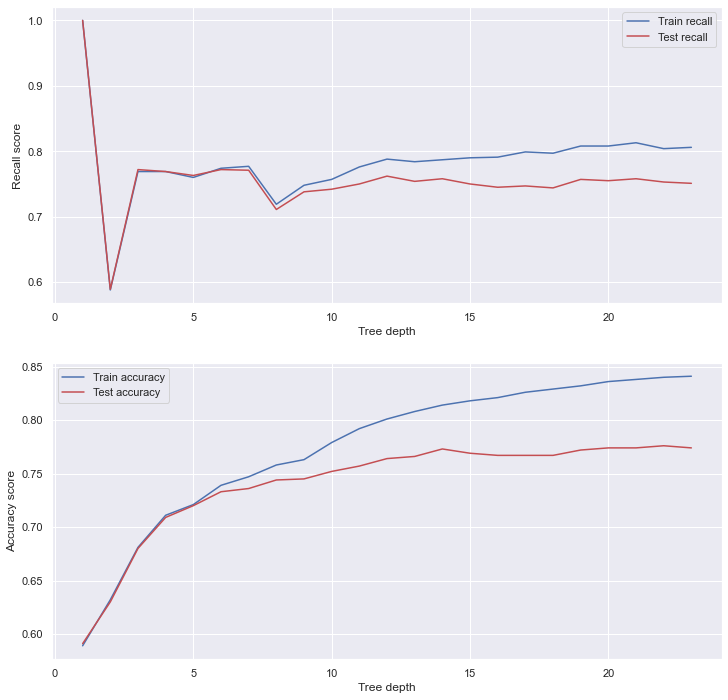

In [113]:
# identify the optimal tree depth for given data
max_depths = list(range(1, 24))
# create empty list for train results
train_recall_results, train_accuracy_results = [], []
# create empty list for test results
test_recall_results, test_accuracy_results = [], []
# iterate over max depths
for max_depth in max_depths:
    # instantiate a DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    # fit to the training data
    dt_clf.fit(X_train, y_train)
    # find what the model predicts for the training data
    y_train_pred = dt_clf.predict(X_train)
    # calculate relevant statistics for training data
    train_recall, train_accuracy = summary(y_train, y_train_pred)
    # add data to list of train results
    train_recall_results.append(train_recall)
    train_accuracy_results.append(train_accuracy)
    # find what the model predicts for the test data
    y_test_pred = dt_clf.predict(X_test)
    # calculate relevant statistics for test data
    test_recall, test_accuracy = summary(y_test, y_test_pred)
    # add data to list of test results
    test_recall_results.append(test_recall)
    test_accuracy_results.append(test_accuracy)
    
# set up the plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12))

# specify the recall plot
ax1.plot(max_depths, train_recall_results, 'b', label='Train recall')
ax1.plot(max_depths, test_recall_results, 'r', label='Test recall')
ax1.set(xlabel='Tree depth', ylabel='Recall score')
ax1.legend()

# specify the accuracy plot
ax2.plot(max_depths, train_accuracy_results, 'b', label='Train accuracy')
ax2.plot(max_depths, test_accuracy_results, 'r', label='Test accuracy')
ax2.set(xlabel='Tree depth', ylabel='Accuracy score')
ax2.legend()

plt.show()

In these plots we're looking for the point just before the train accuracy diverges from the test accuracy, indicating that the train accuracy is improving *more* because the model knows the training set *too well* (overfitting). 

From the accuracy score, this would appear to coincide with a tree depth of at least 6, but that point on the recall score graph could arguably be anywhere between 8 and 12. We'll compromise with a max tree depth of 10.

In [114]:
# instantiate a DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=SEED)
# fit to the training data
dt_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.757    0.779

TEST SET    recall   accuracy
             0.742    0.752


We've sacrificed recall for accuracy, which runs counter to our goals, and this model is not better than the baseline.

Let's use "feature importances" to observe which features mattered most to this model.

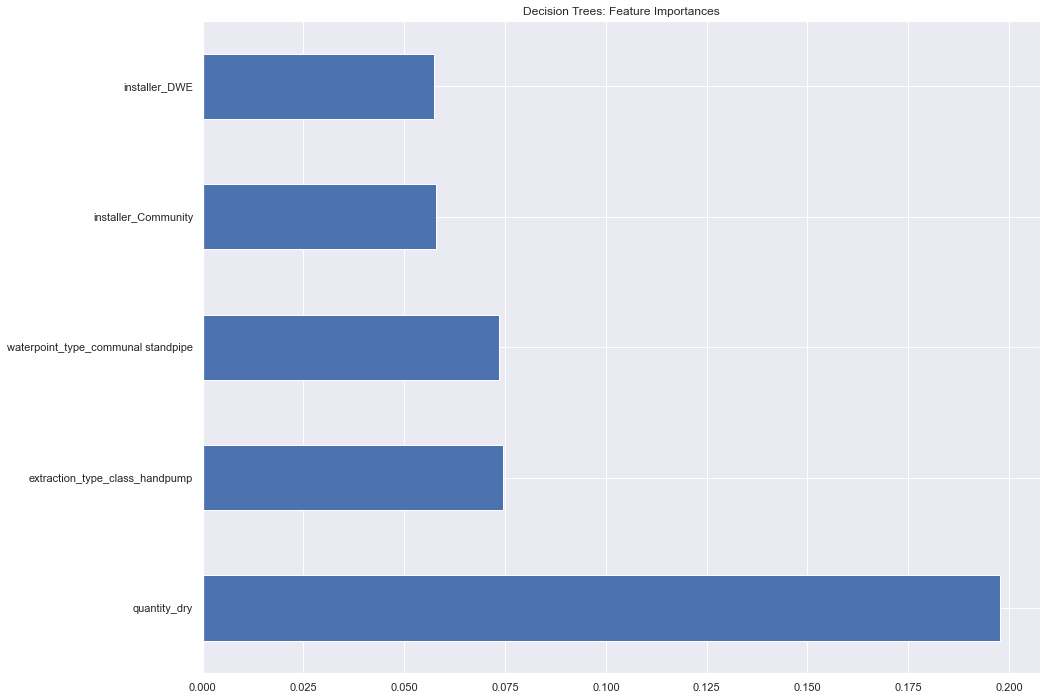

In [115]:
pd.Series(dt_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Decision Trees: Feature Importances'); 

## Bagged trees

This model will train on different subsamples of the training data. We'll set the max depth to 8 and start with 20 estimators.

In [116]:
# instantiate a BaggingClassifier
bt_clf = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=10), n_estimators=20, random_state=SEED)
# fit to the training data
bt_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = bt_clf.predict(X_train)
y_test_pred = bt_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.807    0.804

TEST SET    recall   accuracy
             0.777    0.766


This model performs the best so far in either statistic.

Let's perform a similar analysis to what we did with tree depth earlier to see what the optimal number of estimators might be.

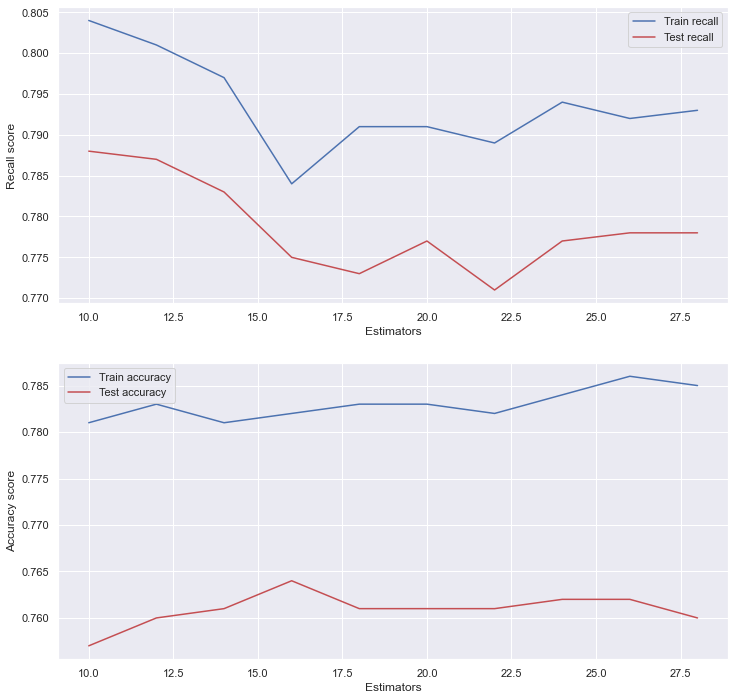

In [117]:
# identify the optimal tree depth for given data
estimator_list = list(range(10,30,2))
# create empty list for train results
train_recall_results, train_accuracy_results = [], []
# create empty list for test results
test_recall_results, test_accuracy_results = [], []
# iterate over max depths
for estimator in estimator_list:
    # instantiate a BaggingClassifier
    bt_clf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=8),
                               n_estimators=estimator, random_state=SEED)
    # fit to the training data
    bt_clf.fit(X_train, y_train)
    # find what the model predicts for the training data
    y_train_pred = bt_clf.predict(X_train)
    # calculate relevant statistics for training data
    train_recall, train_accuracy = summary(y_train, y_train_pred)
    # add data to list of train results
    train_recall_results.append(train_recall)
    train_accuracy_results.append(train_accuracy)
    # find what the model predicts for the test data
    y_test_pred = bt_clf.predict(X_test)
    # calculate relevant statistics for test data
    test_recall, test_accuracy = summary(y_test, y_test_pred)
    # add data to list of test results
    test_recall_results.append(test_recall)
    test_accuracy_results.append(test_accuracy)
    
# set up the plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12))

# specify the recall plot
ax1.plot(estimator_list, train_recall_results, 'b', label='Train recall')
ax1.plot(estimator_list, test_recall_results, 'r', label='Test recall')
ax1.set(xlabel='Estimators', ylabel='Recall score')
ax1.legend()

# specify the accuracy plot
ax2.plot(estimator_list, train_accuracy_results, 'b', label='Train accuracy')
ax2.plot(estimator_list, test_accuracy_results, 'r', label='Test accuracy')
ax2.set(xlabel='Estimators', ylabel='Accuracy score')
ax2.legend()

plt.show()

It's not exactly clear what difference tuning this parameter will make. We'll keep the number of estimators at 20.

## Random Forest

We'll use those same values for a random forest model.

In [118]:
# instantiate a RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=SEED)
# fit to the training data
rf_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.83    0.802

TEST SET    recall   accuracy
             0.809    0.763


This model almost imperceptibly diminishes accuracy but improves recall by about 3%. We'll consider this our new frontrunner. Let's see what features this model considered most important.

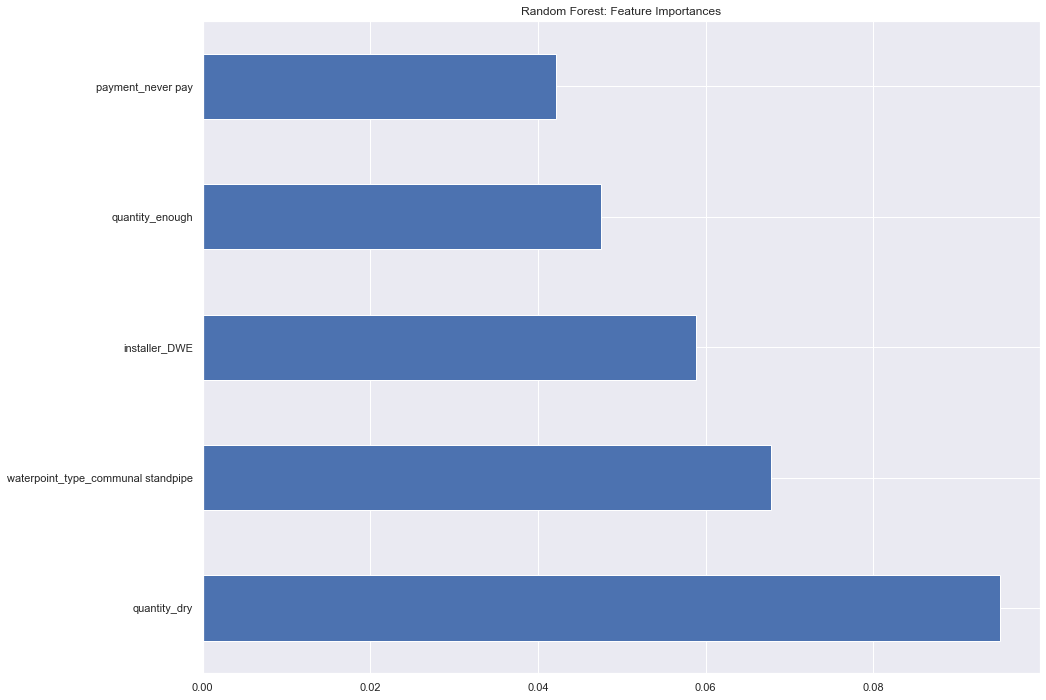

In [119]:
pd.Series(rf_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Random Forest: Feature Importances'); 

## GridSearchCV

This will in theory take the best of all worlds from a decision tree classifier.

In [120]:
# set parameters for grid search
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 6, 8, 11, 15],
    "min_samples_split": [2, 3, 5, 8, 11],
    "min_samples_leaf": [1, 2, 4, 6, 9],
}
# instantiate a GridSearchCV
gscv = GridSearchCV(DecisionTreeClassifier(random_state=SEED), dt_param_grid, cv=3, return_train_score=True)
# fit to the training data
gscv.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = gscv.predict(X_train)
y_test_pred = gscv.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.797    0.826

TEST SET    recall   accuracy
             0.75    0.773


This is a little better than the best accuracy so far, but it sacrifices too much recall in order to get there.

## Adaboost

This model is the classic "adaptive boosting" algorithm, which iteratively prioritizes fixing the previous iterations' mistakes.

In [121]:
# instantiate an AdaBoostClassifier
ad_clf = AdaBoostClassifier(random_state=SEED)
# fit to the training data
ad_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = ad_clf.predict(X_train)
y_test_pred = ad_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.774    0.744

TEST SET    recall   accuracy
             0.781    0.75


This model is good but falls short of the frontrunner in both statistics.

We'll look at what features this algorithm considered most important.

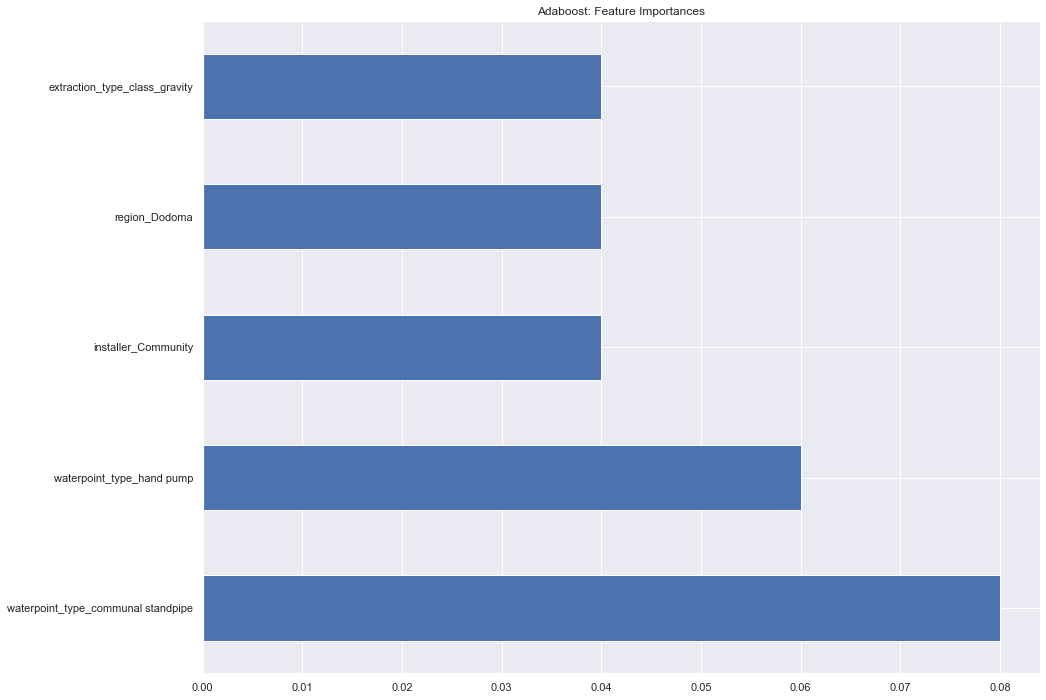

In [122]:
pd.Series(ad_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Adaboost: Feature Importances'); 

## Gradient Boost

This boosting algorithm iteratively learns in a slightly different way from Adaboost, instead using calculus and gradient descent.

In [123]:
# instantiate an GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=SEED)
# fit to the training data
gb_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.779    0.76

TEST SET    recall   accuracy
             0.786    0.757


This model is just a little better than the previous boost model but also falls short of the frontrunner in both statistics.

Here are the feature importances.

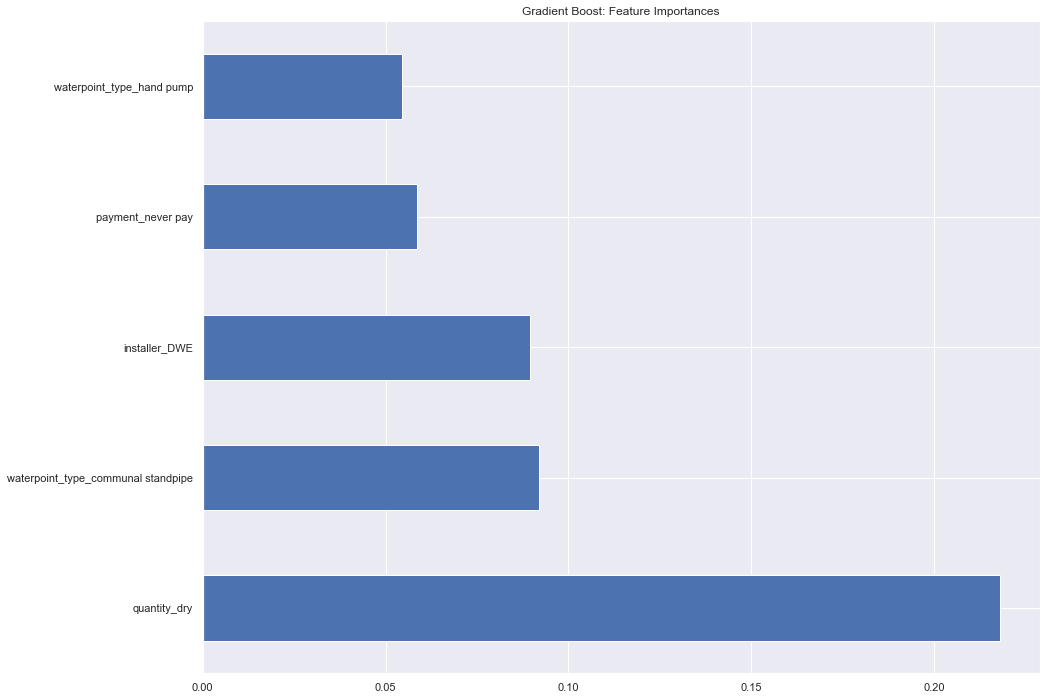

In [124]:
pd.Series(gb_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Gradient Boost: Feature Importances'); 

## XGBoost

XGBoost, or "extreme gradient boost", should produce results as good as or better than any other gradient boost algorithm. Let's see.

In [125]:
# instantiate an XGBClassifier
xg_clf = XGBClassifier()
# fit to the training data
xg_clf.fit(X_train, y_train)
# make predictions for the test data
y_train_pred = xg_clf.predict(X_train)
y_test_pred = xg_clf.predict(X_test)
# show relevant statistics
report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN SET   recall   accuracy
             0.818    0.829

TEST SET    recall   accuracy
             0.777    0.783


This may be the best of the boost models, and it gives the best accuracy score by about 1%, but we do not consider it the best, since it sacrifices too much in the recall score (compared to the current frontrunner, the random forest model).

Let's look at the feature importances.

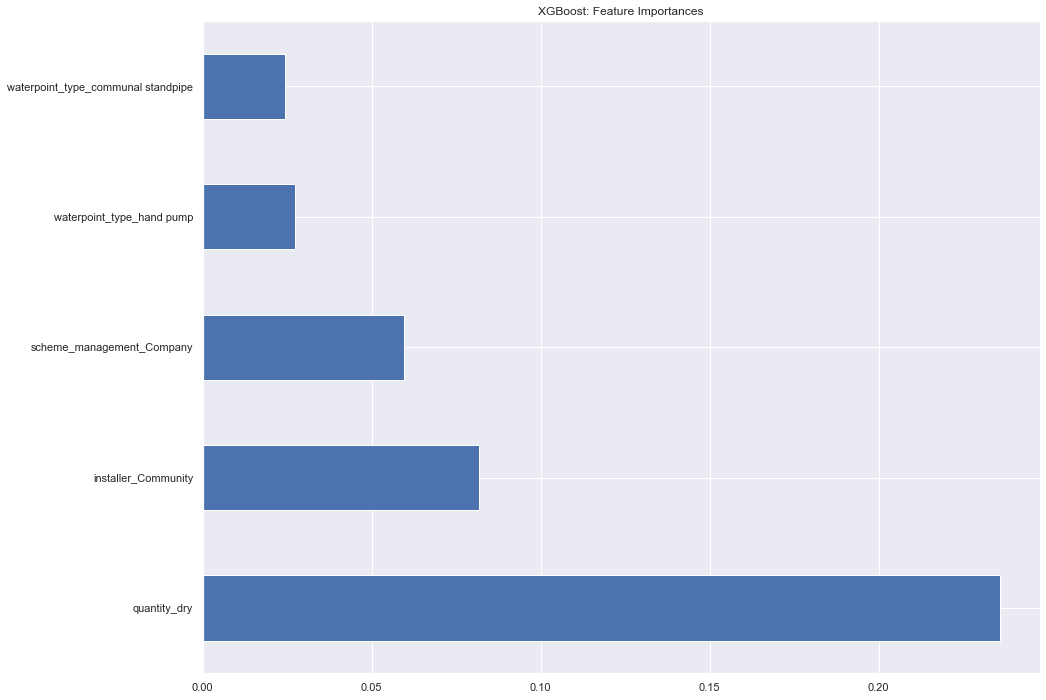

In [126]:
pd.Series(xg_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='XGBoost: Feature Importances'); 

In the end, the random forest model performed the best according to our goals, which prioritized recall of the non-functional wells over accuracy.

# Evaluation

## Feature importances

Five of the models provided us with "feature importances". In four of those (including the favorite), *quantity_dry* was identified as the most important feature to the model. There was also a practical consensus among the models that provided feature importances that *waterpoint_type* was the second most important feature and *installer* was the third.

Let's discuss these features in turn.

### Water quantity

Let's look at the distribution of water quantity values and compare how functional the wells with those values were.

In [127]:
df.quantity.value_counts()

enough          4738
insufficient    3050
dry              983
seasonal         316
unknown           95
Name: quantity, dtype: int64

In [128]:
compare_vals('quantity', ['dry', 'unknown', 'insufficient', 'seasonal', 'enough'])

dry 2%
unknown 19%
insufficient 42%
seasonal 45%
enough 49%


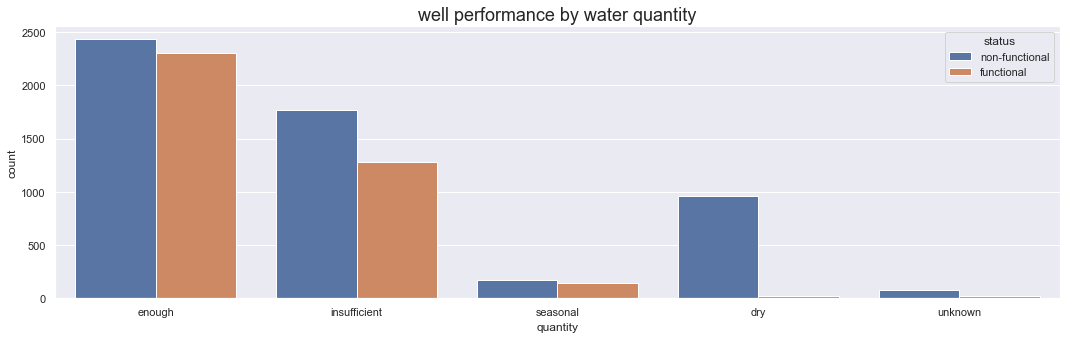

In [129]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='quantity', hue="status", data=df)
# title
ax.set_title('well performance by water quantity', size=18);

About 11% of the wells had a "dry" quantity of water, and virtually **all** of those wells are non-functional. The performance of these wells is clearly and distinctly worse than wells of all other water quantity designations, even "insufficient".

### Waterpoint type

In [130]:
df.waterpoint_type.value_counts()

communal standpipe             5312
communal standpipe multiple    1417
hand pump                      1195
other                          1151
improved spring                  77
cattle trough                    30
Name: waterpoint_type, dtype: int64

In [131]:
compare_vals('waterpoint_type', [
    'other', 'communal standpipe multiple', 'communal standpipe', 'hand pump', 'cattle trough', 'improved spring'])

other 10%
communal standpipe multiple 23%
communal standpipe 49%
hand pump 52%
cattle trough 67%
improved spring 79%


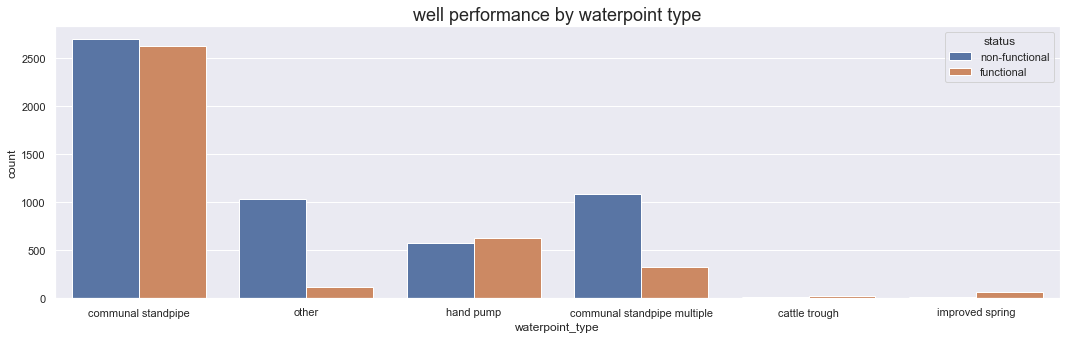

In [132]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='waterpoint_type', hue="status", data=df)
# title
ax.set_title('well performance by waterpoint type', size=18);

There aren't really enough examples of cattle trough and improved spring types to draw hard conclusions, and unfortunately we don't know what "other" even means. We also don't know exactly what the "multiple" designation indicates.

Therefore cautiously draw two conclusions about waterpoint type:
1. "Multiple" communal standpipes are inferior to whatever non-multiple standpipes are.
2. Greater efforts should be made to record the waterpoint type so that the failure of the "other" category can be better understood.

### Installer

In [133]:
df.installer.value_counts()

DWE                 4313
Government          2726
RWE                  649
Other                544
District Council     489
Community            461
Name: installer, dtype: int64

In [134]:
compare_vals('installer', ['Government', 'Other', 'District Council', 'DWE', 'Community'])

Government 30%
Other 32%
District Council 33%
DWE 50%
Community 75%


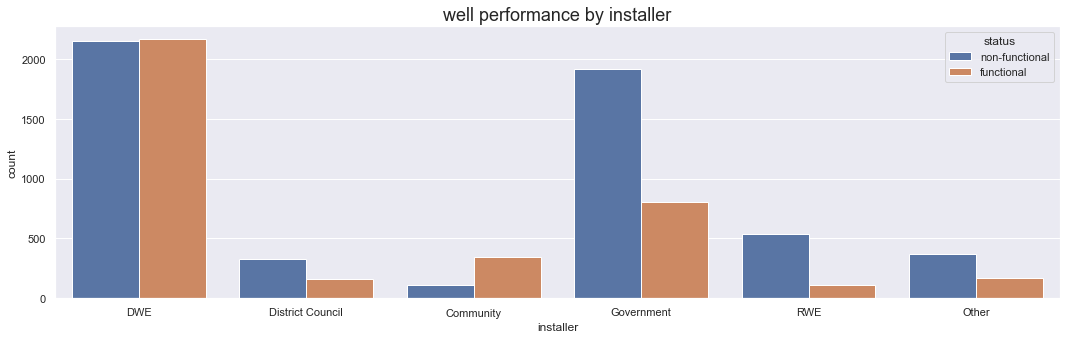

In [135]:
# set figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
# plot well performance
ax = sns.countplot(x='installer', hue="status", data=df)
# title
ax.set_title('well performance by installer', size=18);

A cursory search did not reveal just what RWE or DWE are. All we can say is that, insofar as an installer option exists, the data here should guide that choice.

# Recommendations

In all three of the important features we discussed, we don't know exactly how much control the government has in choosing among the available options. Insofar as the government has a choice, they should ...

1. place wells in areas with sufficient water quantity
2. favor handpump and communal standpipe waterpoint types over communal standpipe *multiple* waterpoint types
3. have wells installed by the community

However (and wherever) the wells are placed, the government should commit more resources to monitoring wells that ...

1. are placed in areas of low water quantity
2. are of communal standpipe *multiple* waterpoint type
3. were installed by an organization other than the community or DWE (especially wells installed by RWE)
4. were installed before 1985

In all instances, the government should also monitor wells that ...

5. have some or many unknown data points, particularly in the areas of water quantity, waterpoint type, and installer.

# Further inquiry

Much of this data was unusable that may have otherwise been rather helpful. We would encourage better data gathering especially in the areas relevant to our recommendations — water quantity level, waterpoint type, and installer identity.

In some cases, it appeared that the "other" or "unknown" labels for a column corresponded with well failure. From this trend we have surmised that perhaps there is some other explanatory variable that correlates highly with well failure and lack of information. This is difficult to demonstrate in modeling, however. More reliable data could help with this.

It would also be helpful to know more about what constraints exist on the choices we've presented. If, for example, we knew how much it cost to implement the different types of wells, we could do additional analysis on which wells were more effective *per dollar spent*. Or it could be helpful to know how the government works with various installers, how much it costs to outsource that tasks to various groups, and where those groups are and aren't available to handle installation.